## Resources

https://drive.google.com/drive/folders/1VD8J-zYix3mD31jbIBhqK2fke-

https://github.com/nlpcuom/WEIntrinsicEvaluation

## Obectives

1. Experiment CBOW and skip gram model with LOgistic regression, SVC, Random forest with df_A,df_B,df_C
2. Train own wor2vec - #TODO
3. Fine tuning word2vec  #TODO
4. Affect of stemmming
    1. no stemming
    2. stemmed with longer suffixx
    3. stemmed with shorter suffix

## Observations

1. Word embedding CBOW and skip gram both perform worser than traditiona feature extraction methods
2. It can be observed CBOW perform better than skipgram
3. SVC perform worser and gave very low values
4. Not only recall is low overall precison is low
5. There is no punctuation,number, english words similarity in common crawl word2vec so all punctuation,numbers,noise need to be remove
6. conducted all preprocessing by setting stemming as variable longer suffix stemming performed better

## Posible reasons
1. Since we are averaging 300 dimentional vectors we are not getting maximum outcome of word2vec
2. Word2vec cannot handle OOV which is very common in this hate speech detection
3. Common Crawl and distribution dataset is different 

## Further investigations and solutions
1. Training our own word2vec using informal sinhala text documents/ combining all four datasets?
2. Fine tuning word2vec
4. Possible solutions to handle OOV instead of setting random value
5. Investigate affect of stemming

## Word2vec model with logistic regression

size: The number of dimensions of the embeddings and the default is 100.

window: The maximum distance between a target word and words around the target word. The default window is 5.

min_count: The minimum count of words to consider when training the model; words with occurrence less than this count will be ignored. The default for min_count is 5.

workers: The number of partitions during training and the default workers is 3.

sg: The training algorithm, either CBOW(0) or skip gram(1). The default training algorithm is CBOW

## Load modules and datasets

In [1]:
import neptune
from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report,log_confusion_matrix,log_prediction_distribution
from neptunecontrib.api import log_table
import os
from dotenv import load_dotenv

load_dotenv()
NEPTUNE_PROJECT= os.getenv('NEPTUNE_PROJECT')
NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
neptune.init(project_qualified_name= NEPTUNE_PROJECT,api_token=NEPTUNE_API_TOKEN) 
             

Project(codekcg23/Research-Experiments)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
#from sklearn.metrics import accuracy_score, f1_score, precision_score,roc_curve,roc_auc_score,confusion_matrix,recall_score
from sklearn.pipeline import Pipeline
import re
import gensim

# import helper function script
import sys
sys.path.insert(1,'G:\\Github\\Sinhala-Hate-Speech-Detection')
import utills
import sinhala_stemmer

In [3]:
# load datasets
path = '../Datasets/processed/preprocessed/'
df_A = pd.read_csv(path+'df_A.csv')    
df_B = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle 
df_A_B = pd.read_csv(path+'df_A_B.csv') 


In [11]:
df_A.drop(index =[610,3070],inplace=True)
df_B.drop(index =[16,19],inplace=True)
df_A_B.drop(index =[610,3070,6484,6487],inplace=True)

In [33]:
# load datasets
path = '../Datasets/processed/preprocessing/'
df_A_p = pd.read_csv(path+'df_A.csv')    
df_B_p = pd.read_csv(path+'df_B.csv')    # fb dataset -kaggle 
df_A_B_p = pd.read_csv(path+'df_A_B.csv') 


## Load word2vec models and test

### skip gram

In [4]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/word2vec/word2vec_300.w2v")
path = "../Embedding_models/cbow_300.w2v"



In [6]:
print(model.wv.most_similar('ලැජ්ජයි'))
print(model.wv.most_similar('මෑරෙන්න'))
print(model.wv.most_similar('යකො'))
print(model.wv.most_similar('හොරා'))
print(model.wv.most_similar('බල්ලා'))
print(model.wv.most_similar('තම්බි'))
print(model.wv.most_similar('හුත්ති'))
print(model.wv.most_similar('මුස්ලිම්'))
print(model.wv.most_similar('මුස්ලිම'))
print(model.wv.most_similar('සිංහල'))
print(model.wv.most_similar('වෛරය'))
print(model.wv.most_similar(['අම්මා']))
print(model.wv.most_similar(['ගෙදර']))

[('ෂිකේ.', 0.624288022518158), ('දැක්කහමමචං', 0.606025218963623), ('අසරනට', 0.6009397506713867), ('ගානවාවල', 0.5993783473968506), ('තිලකයියේ', 0.5935572385787964), ('නාගෙනදඟලන්න', 0.5622760057449341), ('හිත්න්නත්', 0.5605373978614807), ('ආණ්දුව', 0.5562554597854614), ('්ගමයාවිලි', 0.5535441637039185), ('දැක්කම\tපිනා', 0.5499239563941956)]
[('හෑබෑමයි', 0.6853367686271667), ('වෙන්නජීවත්', 0.615235447883606), ('වෙලාවකඉපදුනේ', 0.5789225101470947), ('හෙටවෙයිද', 0.5657752752304077), ('ලෑස්තිවෙයල්ල', 0.5579881072044373), ('\u200dබොම්බ', 0.5476895570755005), ('දෙයක්අන්ඩුවට', 0.5422118306159973), ('දෑක්කනම්', 0.5235146880149841), ('ෆොන්නඩෝටත්', 0.5233187675476074), ('වෑස්සටවත්', 0.5230247974395752)]
[('යකෝ', 0.6215049624443054), ('පුරුන්ග', 0.5947710871696472), ('හොයපි', 0.5878672003746033), ('වේසික', 0.5774468779563904), ('සඳරුවණ්', 0.5767057538032532), ('බන්', 0.5762976408004761), ('පෑන්චියො', 0.5738309621810913), ('මේරටෙ', 0.5726816058158875), ('තිරිසනාතොපෙ', 0.572677731513977), ('දුශ්ඨයෙක්ට

In [7]:
words_skipgram = list(model.wv.vectors)
print(len(words_skipgram))
print(model)

2137729
Word2Vec(vocab=2137729, vector_size=300, alpha=0.025)


### CBOW

In [5]:
from gensim.models import word2vec
model_cbow = word2vec.Word2Vec.load("G:/Github/Sinhala-Hate-Speech-Detection/Embedding_models/CBOW-word2vec/cbow_300.w2v")
path = "../Embedding_models/cbow_300.w2v"

In [9]:
print(model_cbow.wv.most_similar('ලැජ්ජයි'))
print(model_cbow.wv.most_similar('මෑරෙන්න'))
print(model_cbow.wv.most_similar('යකො'))
print(model_cbow.wv.most_similar('හොරා'))
print(model_cbow.wv.most_similar('බල්ලා'))
print(model_cbow.wv.most_similar('හුත්ති'))
print(model_cbow.wv.most_similar('තම්බි'))
print(model_cbow.wv.most_similar('මුස්ලිම්'))
print(model_cbow.wv.most_similar('මුස්ලිම'))
print(model_cbow.wv.most_similar('සිංහල'))
print(model_cbow.wv.most_similar('වෛරය'))
print(model_cbow.wv.most_similar(['අම්මා']))
print(model_cbow.wv.most_similar(['ගෙදර']))

[('බයයි', 0.6065513491630554), ('කනගාටුයි', 0.5837079882621765), ('අප්පිරියයි', 0.5734831094741821), ('කේන්තියි', 0.5662340521812439), ('හිරිකිතයි', 0.5526554584503174), ('බෑ', 0.5475850701332092), ('ලෝබයි', 0.533913254737854), ('දුකයි', 0.5273364782333374), ('අමරුයි', 0.5127739310264587), ('බැහැනේ', 0.5030311346054077)]
[('හෑබෑමයි', 0.6160866618156433), ('මැරුනහැකි', 0.4991958737373352), ('මැරෙන්න', 0.4926010072231293), ('මෑරෙන', 0.48189735412597656), ('මැාරන', 0.4802682399749756), ('කන්නමනෙ', 0.4776369631290436), ('නොකෑටික', 0.47728267312049866), ('මෑරෙන්නය', 0.4690975546836853), ('කබරගොයිවත්', 0.4473191499710083), ('අදරයකරන්නේ', 0.4471481740474701)]
[('යකෝ', 0.6595990657806396), ('බන්', 0.6435429453849792), ('බොල', 0.586578369140625), ('හුත්තෝ', 0.584592342376709), ('😢', 0.5755847692489624), ('උබෙ', 0.5713131427764893), ('තොපෙ', 0.5639413595199585), ('🔫', 0.562926709651947), ('අඩො', 0.5561082363128662), ('මචන්', 0.5551674365997314)]
[('හොරු', 0.5437721610069275), ('හොරෙන්', 0.534941

In [10]:
words = list(model_cbow.wv.vectors)
print(len(words))
print(model_cbow)
#print(words[10])

2137729
Word2Vec(vocab=2137729, vector_size=300, alpha=0.025)


## Embedding Mapping

In [16]:
# def word_avg_vector(model,words_list):
#     if len(words_list) < 1:  # whole sentence has no words or nan
#         return np.zeros(300)
#     else:
#         vectorized = [model[word] if word in model else np.zeros(300) for word in words_list]
#     # doc = [word for word in doc if word in model.wv.index_to_key else np.random.rand(k)]
#     return np.mean(vectorized, axis=0)

# TODO function for word_tfidf_avg_vector
words_not_found = []
def word_avg_vector(model,words_list):
    if len(words_list) < 1:  # whole sentence has no words or nan
        return np.zeros(300)
    else:
        vectorized = []
        for word in words_list:
          if word in model:
            #print("word vector length",len(model[word]))
            vectorized.append(model[word])
          else:
            vectorized.append(np.zeros(300))
            words_not_found.append(word)
        #vectorized = [model[word] if word in model else np.zeros(300) for word in words_list]
        #print(vectorized)
        #print("vectorized array len ",len(vectorized),np.array(vectorized).shape)
    # doc = [word for word in doc if word in model.wv.index_to_key else np.random.rand(k)]
    #print('average embedding shape',np.mean(vectorized, axis=0).shape)
    return np.mean(vectorized, axis=0)

def get_embedding(df,model):
    # TODO add option to select TFIDF vs mean embedding
    # avg vector
    embeddings = df.apply(lambda x: word_avg_vector(model,x.split()))

    # tfidf weighted vector
    return list(embeddings)
def word2vec_skipgram_embedding(X_train,X_test):
    # initialize model
    # TODo initialize word2vec model here for partucular dataset
    X_train_embeddings = get_embedding(X_train,model.wv)
    X_test_embeddings = get_embedding(X_test,model.wv)
    return X_train_embeddings,X_test_embeddings
def word2vec_cbow_embedding(X_train,X_test):
    # initialize model
    
    # TODo initialize word2vec model here for partucular dataset
    X_train_embeddings = get_embedding(X_train,model_cbow.wv)
    X_test_embeddings = get_embedding(X_test,model_cbow.wv)
    return X_train_embeddings,X_test_embeddings
    
# also check evalaution metric from prediction
# you can check both cross validated and hold out yureka cross validated only using trainig set

In [ ]:
token = Tokenizer()
token.fit_on_texts(X_train)
word_index = token.word_index
print("dictionary size: ", len(word_index))

In [ ]:
import numpy as np
embeddings_index = {}
for i, line in enumerate(open('/content/drive/My Drive/Research Project/Notebooks/cc.si.300.vec')):
    values = line.split()
    embeddings_index[values[0]] = np.asarray(values[1:], dtype='float32')
print('found %s word vectors' % len(embeddings_index))

In [ ]:
def word_mapping(word_index):
    words_not_found=[]
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: #and len(embedding_vector) > 0
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.randn(300)
            words_not_found.append(word)
    print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
    #print("sample words not found: ", np.random.choice(words_not_found, 200))
    print("Number of words not found",len(words_not_found))
    print("Propotion of oov ",(len(words_not_found)/len(word_index))*100)
    return embedding_matrix

## OOV Count investigation

In [15]:
words_not_found =[]
emb_skipgram = get_embedding(df_A['cleaned'], model.wv)
#print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 200))
print("Number of words not found",len(words_not_found))
#print("Propotion of oov ",(len(words_not_found)/len(word_index))*100)


sample words not found:  ['බුදියගන' 'ඳිල' 'කක්කුස්ස' 'හොරෙක්න' 'වෙඩේම' 'දේශපාලකයනු' 'කොරපා'
 'භාණ්ඩාගාරයකු' 'පොන₹€¥' 'දේශණාක' 'බුදියගෙ' 'පාස්පෝට' 'රිපෝර්ට' 'ලොල්ලන'
 'හර්දසාක්ස' 'මැකෙ' 'ඉන්ක' 'දකිනකො' 'වටලද්දි' 'ජීවිතාන්න' 'එකොම' 'නහග'
 'කයිවාර' 'ප්\u200dරෝඩාවන' 'ජෝක්ස' 'හැංග' 'දිට්ඨධම්මවේදන' 'වොරැන්ටි'
 'පිලගෙ' 'ගලවාගැන' 'තිරිස' 'පරවෙද' 'මයිනස' 'කියාදීහ' 'කම්පැ' 'හම්බව'
 'ටෝක්ස' 'පස්චා' 'අපකීරති' 'තෙවා' 'තොටුප' 'වැසික' 'රැග්ද' 'ඒකෙදිමන' 'ෂෝරූ'
 'මංතීරුටික' 'ඡන්ඳෙ' 'ජනාදිප' 'දුක්ඛදාය' 'බානකට' 'කෙළවෙ' 'පෙලෝසි' 'මතබෑව'
 'විශිශ්ටත්ව' 'ඩික්ම' 'කෙළසෙ' 'ටැපලු' 'මහලො' 'හැප්පෙනවැ' 'ත්\u200dරීවිල'
 'අටවගනින්ක' 'ගොසිප්බු' 'කැක්ක' 'හාමුුරු' 'වහල්ලුන' 'යොදාගෙ' 'කව්ර'
 'ටුයිට' 'ප්\u200dරාර්ථ' 'ට්\u200dර\u200dම්ප' 'ගිනිතිව්' 'එකාටන' 'බලලෝභ'
 'ට්\u200dරෙන්ඩ' 'සාරධර්' 'බැරිමන' 'කපටියින' 'දෙමාප' 'පේනවන' 'මුස්කි'
 'හමබයො' 'පළිග' 'විවිඪ' 'ආන්ස්ෆර' 'පැටෙව' 'සිල්වාලාන' 'නහුටු' 'ඉස්සරවෙ'
 'සුරැකුම්ප' 'යෙහො' 'සාක්ච්ඡ' 'ඕවර්ඩෝස' 'දහදු' 'ජිගියදාද්දි' 'කම්පැ'
 'පර්\u200dභාකර' 'කක්කුස්සියකු' 'මැහ' 'වනනකො' 'ස්ටේ

In [18]:
words_not_found =[]
emb_cbow = get_embedding(df_A['cleaned'], model_cbow.wv)
#print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))
print("sample words not found: ", np.random.choice(words_not_found, 200))
print("Number of words not found",len(words_not_found))
#print("Propotion of oov ",(len(words_not_found)/len(word_index))*100)

sample words not found:  ['දගපන්ද' 'පාවාදීමන' 'ජාතිකයොල' 'ලුසීඩ' 'නිවන්ස' 'ස්ටේටස' 'පුන්නක්'
 'හැප්පෙනවැ' 'ප්රීත' 'තාජු' 'කලාන' 'බුදියගෙ' 'ලෝගව' 'යක්ෂණ' 'හැප්පෙ'
 'ඩුබ්' 'සිංගප්පූර' 'ෆේස්බු' 'කොස්ග' 'පාර්ළි\u200d\u200dමෙන්තු' 'ජේවීප'
 'නොමිනේෂ' 'පාවාදෙ' 'ප්\u200dර\u200dවෘත්ත' 'හොරාකාප' 'මැදමුල' 'කෝටිප'
 'හිගාක' 'නැමැය' 'තේරෙරෙ' 'එක්කගෙ' 'බණි' 'හිටියාන' 'සුභපැත' 'දැක්කාමන'
 'ධර්මලිංග' 'නිදාගෙ' 'පික්ස්ස' 'විකුණගෙ' 'කාණුකට' 'ෂෝ්' 'හරිහාම' 'කන්නැත'
 'තියෙනකො' 'රිපෝර්ට' 'හතරවෙ' 'සුදුසුක' 'කඩඉමක්න' 'මුලිනුපුට'
 'ප්\u200dරශංසණී' 'සෙන්ට්\u200dර\u200dල' 'කෙසේනමු' 'ගොසිප්ප' 'කාලකණ්'
 'කපාගෙ' 'අලිගැ' 'මොකාදැ' 'බේබි' 'තෛපොංගල' 'ලටඔයා' 'සිිකරගත්' 'ෆුල්ෆේස'
 'කාලකණ්' 'ඉබෙිම' 'කුලල්කෑ' 'හම්සව' 'දකිනකො' 'සිිකරගත්' 'පොඩිිිිඩ'
 'පාරෙමයින' 'මයෙහිත' 'වරෙංක' 'පැස්ටොල' 'යද්දිල' 'මහසොහො' 'ඉටිගෙඩ' 'බේබි'
 'මින්ස්ස' 'ඉස්සරවෙ' 'සෙරෙපුවක්' 'දූෂණයකද' 'හැන්ඩ්ස' 'කියමුක' 'පිණිබිද'
 'ෆිට්නස' 'වැසික' 'කාලකණ්' 'කැළෑගතවුන' 'හිතුවන' 'කැමපස' 'එමිරේට්ස්ල'
 'මංජේකාර' 'එමිරේට්ස' 'වන්දිබට්ටක' 'ගොසිප්ප' 'පික්ස්ස' 'මෝ්ල්'
 '

## Train wordvec model with dataset

In [ ]:
# X_train, X_test, Y_train, Y_test = utills.prepare_dataset(df_A, "df_A")
# train_corpus = [x.split() for x in X_train]
# test_corpus = [x.split() for x in X_test]  

In [ ]:
# model = gensim.models.Word2Vec(train_corpus,
#                                vector_size=300,
#                                window=100,
#                                min_count=10,
#                                sample=1e-3)
# print(model.wv)
# print(len(model.wv.vectors))

In [ ]:
# def average_word_vectors(words, model, vocabulary, num_features):

#     feature_vector = np.zeros((num_features,), dtype="float64")
#     nwords = 0.

#     for word in words:
#         if word in vocabulary:
#             nwords = nwords + 1.
#             feature_vector = np.add(feature_vector, model[word])

#     if nwords:
#         feature_vector = np.divide(feature_vector, nwords)

#     return feature_vector
    
# def averaged_word_vectorizer(corpus, model, num_features):
#     vocabulary = set(model.index_to_key)
#     features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
#                 for tokenized_sentence in corpus]
#     return np.array(features)

In [ ]:
# avg_wv_train_features = averaged_word_vectorizer(corpus=train_corpus,
#                                                  model=model.wv,
#                                                  num_features=300)
# avg_wv_test_features = averaged_word_vectorizer(corpus=test_corpus,
#                                                 model=model.wv,
#                                                 num_features=300)
# lr = LogisticRegression()
# lr.fit(avg_wv_train_features,Y_train)
# Y_pred_avg_w2v=lr.predict(avg_wv_test_features)

## Another apporach using pipeline

In [ ]:



# # The train and test data was converted to list of strings since word2vec requires that
# #train_corpus = [" ".join() for x in X_train]
# train_corpus = [x.split() for x in X_train]
# test_corpus = [x.split() for x in X_test]  

# import gensim
# # let X be a list of tokenized texts (i.e. list of lists of tokens)
# # skip gram model - good for high morphological languafes
# model = gensim.models.Word2Vec(train_corpus, vector_size=300,window = 10,min_count=1,sg=1)
# print(model.wv)
# print(len(model.wv.vectors))
# w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))


# class MeanEmbeddingVectorizer(object):
#     def __init__(self, word2vec,size = 300):
#         self.word2vec = word2vec
#         # if a text is empty we should return a vector of zeros
#         # with the same dimensionality as all the other vectors
#         self.dim = size #len(word2vec.itervalues().next())

#     def fit(self, X, y):
#         return self

#     def transform(self, X):
#         return np.array([
#             np.mean([self.word2vec[w] for w in words if w in self.word2vec]
#                     or [np.zeros(self.dim)], axis=0)
#             for words in X
#         ])


## Test with logistic regression pretrained CBOW and skipgram (Common crawl)

### Helper functions

In [19]:
folder_path = 'G:\\Github\\Sinhala-Hate-Speech-Detection\\Datasets\\processed\\preprocessed\\'
def classifier_feature(datasets,models,features):
    final_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
    for df_name,df in datasets.items():
        df_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
        #X_train,X_test,Y_train,Y_test = utills.prepare_dataset(df,df_name)

        ## -- shorter stem --
        #df = utills.preprocessor(df, 'comment',custom_stem_shorter=True)

        ## -- longer stem --
        #df = utills.preprocessor(df, 'comment')
        #df.to_csv(os.path.join(folder_path,f'{df_name}.csv'), index=False)

        X_train, X_test, Y_train, Y_test = train_test_split(df['cleaned'], df['label'], test_size=0.3, random_state=0, stratify=df['label'].values)
        
        for feature_name,feature in features.items():
            feature_result =pd.DataFrame(columns=['Accuracy','F1-score','Recall','Precision','AUC'])
            X_train_f,X_test_f = feature(X_train,X_test)
            for model_name,model in models.items():
                name = df_name + "+" + feature_name+ "+"+ model_name
                print(name)
                Y_pred = model(X_train_f,X_test_f,Y_train)
                accuracy, f1_score, recall, precision, auc = utills.result(Y_test,Y_pred)
                final_result.loc[name] = [accuracy, f1_score, recall, precision, auc]
                feature_result.loc[model_name] =[accuracy, f1_score, recall, precision, auc]
                key =model_name + "+"+ feature_name
                df_result.loc[key] = [accuracy, f1_score, recall, precision, auc]
                log_result(Y_test,Y_pred,name,df_name,feature_name,model_name)
            print(" ==== ",feature_name ," ==== ")
            display(feature_result)
            log_table(feature_name,feature_result)
        print(" ==== ",df_name ," ==== ")
        display(df_result)
        log_table(df_name,df_result)
    display(final_result)
    log_table(name,final_result)



In [20]:
def log_result(Y_test, Y_pred, name, df_name, feature_name, model_name):

    import neptune
    from neptunecontrib.monitoring.metrics import expand_prediction, log_class_metrics, log_binary_classification_metrics, log_classification_report, log_confusion_matrix, log_prediction_distribution
    from neptunecontrib.api import log_table
    import os
    from dotenv import load_dotenv

    load_dotenv()
    NEPTUNE_PROJECT = os.getenv('NEPTUNE_PROJECT')
    NEPTUNE_API_TOKEN = os.getenv(('NEPTUNE_API_TOKEN'))
    neptune.init(project_qualified_name=NEPTUNE_PROJECT,
                 api_token=NEPTUNE_API_TOKEN)

    print("========= Eperiment - ", name, " =========")
    neptune.create_experiment(name)
    neptune.append_tag(["Word2Vec Embedding redo",df_name,feature_name, model_name, name])

    log_class_metrics(Y_test, Y_pred)
    log_confusion_matrix(Y_test, Y_pred)
    log_classification_report(Y_test, Y_pred)

## Evaluate with split() funciton

df_A+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1336
           1       0.71      0.57      0.63       604

    accuracy                           0.79      1940
   macro avg       0.77      0.73      0.74      1940
weighted avg       0.79      0.79      0.79      1940



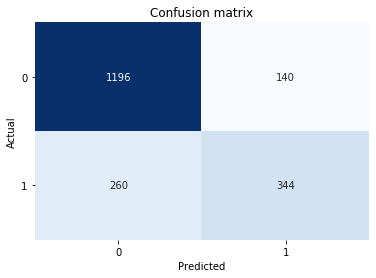

========= Eperiment -  df_A+W2V skipgram+LR  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-401
df_A+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1336
           1       0.70      0.58      0.64       604

    accuracy                           0.79      1940
   macro avg       0.76      0.73      0.74      1940
weighted avg       0.79      0.79      0.79      1940



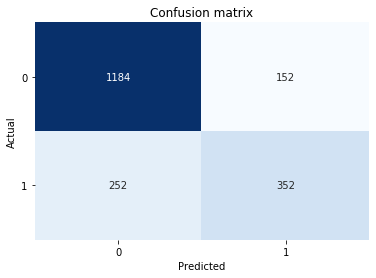

========= Eperiment -  df_A+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-402
df_A+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.85      0.47      0.61      1336
           1       0.41      0.82      0.55       604

    accuracy                           0.58      1940
   macro avg       0.63      0.64      0.58      1940
weighted avg       0.71      0.58      0.59      1940



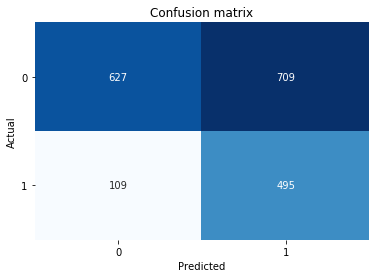

========= Eperiment -  df_A+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-403
df_A+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.79      0.96      0.86      1336
           1       0.81      0.42      0.55       604

    accuracy                           0.79      1940
   macro avg       0.80      0.69      0.71      1940
weighted avg       0.79      0.79      0.77      1940



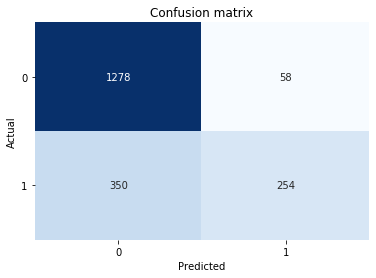

========= Eperiment -  df_A+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-404
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.793814,0.632353,0.569536,0.710744,0.732373
SVC linear,0.791753,0.635379,0.582781,0.698413,0.734505
NB,0.578351,0.547566,0.819536,0.411130,0.644424
RF,0.789691,0.554585,0.420530,0.814103,0.688558


df_A+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1336
           1       0.69      0.54      0.61       604

    accuracy                           0.78      1940
   macro avg       0.75      0.72      0.73      1940
weighted avg       0.77      0.78      0.77      1940



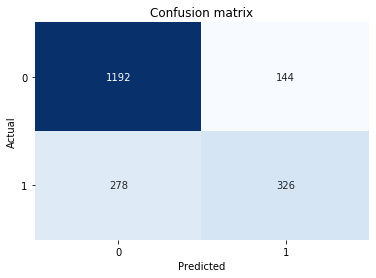

========= Eperiment -  df_A+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-405
df_A+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.81      0.89      0.85      1336
           1       0.69      0.53      0.60       604

    accuracy                           0.78      1940
   macro avg       0.75      0.71      0.72      1940
weighted avg       0.77      0.78      0.77      1940



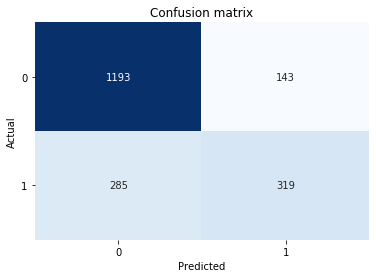

========= Eperiment -  df_A+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-406
df_A+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.84      0.46      0.60      1336
           1       0.40      0.80      0.54       604

    accuracy                           0.57      1940
   macro avg       0.62      0.63      0.57      1940
weighted avg       0.70      0.57      0.58      1940



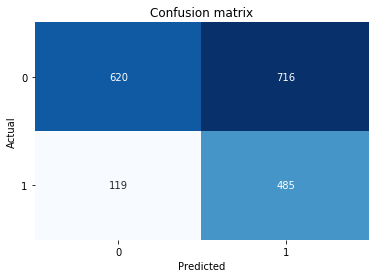

========= Eperiment -  df_A+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-407
df_A+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      1336
           1       0.82      0.36      0.50       604

    accuracy                           0.78      1940
   macro avg       0.80      0.66      0.68      1940
weighted avg       0.79      0.78      0.74      1940



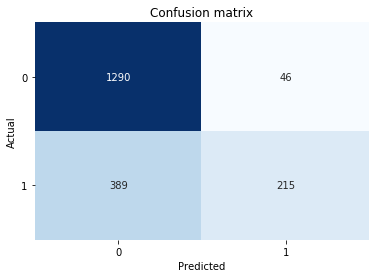

========= Eperiment -  df_A+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-408
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.782474,0.607076,0.539735,0.693617,0.715975
SVC linear,0.779381,0.598499,0.528146,0.690476,0.710555
NB,0.569588,0.537396,0.802980,0.403830,0.633526
RF,0.775773,0.497110,0.355960,0.823755,0.660765


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.793814,0.632353,0.569536,0.710744,0.732373
SVC linear+W2V skipgram,0.791753,0.635379,0.582781,0.698413,0.734505
NB+W2V skipgram,0.578351,0.547566,0.819536,0.411130,0.644424
RF+W2V skipgram,0.789691,0.554585,0.420530,0.814103,0.688558
LR+W2V CBOW,0.782474,0.607076,0.539735,0.693617,0.715975
SVC linear+W2V CBOW,0.779381,0.598499,0.528146,0.690476,0.710555
NB+W2V CBOW,0.569588,0.537396,0.802980,0.403830,0.633526
RF+W2V CBOW,0.775773,0.497110,0.355960,0.823755,0.660765


df_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.83      0.80      0.81       866
           1       0.84      0.86      0.85      1037

    accuracy                           0.83      1903
   macro avg       0.83      0.83      0.83      1903
weighted avg       0.83      0.83      0.83      1903



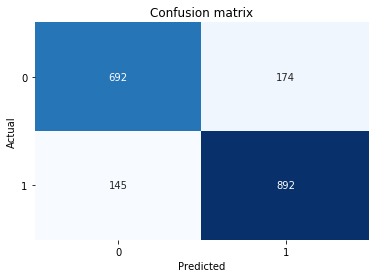

========= Eperiment -  df_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-409
df_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       866
           1       0.82      0.86      0.84      1037

    accuracy                           0.82      1903
   macro avg       0.82      0.82      0.82      1903
weighted avg       0.82      0.82      0.82      1903



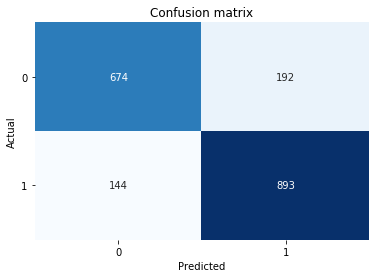

========= Eperiment -  df_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-410
df_B+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.72      0.54      0.62       866
           1       0.68      0.82      0.75      1037

    accuracy                           0.70      1903
   macro avg       0.70      0.68      0.68      1903
weighted avg       0.70      0.70      0.69      1903



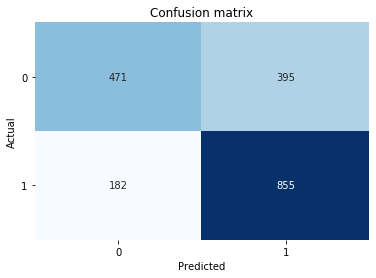

========= Eperiment -  df_B+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-411
df_B+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       866
           1       0.86      0.82      0.84      1037

    accuracy                           0.83      1903
   macro avg       0.83      0.83      0.83      1903
weighted avg       0.83      0.83      0.83      1903



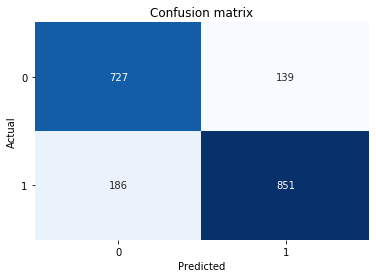

========= Eperiment -  df_B+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-412
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.832370,0.848312,0.860174,0.836773,0.829625
SVC linear,0.823437,0.841659,0.861138,0.823041,0.819714
NB,0.696795,0.747704,0.824494,0.684000,0.684187
RF,0.829217,0.839665,0.820636,0.859596,0.830064


df_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.80      0.77      0.78       866
           1       0.81      0.84      0.83      1037

    accuracy                           0.81      1903
   macro avg       0.81      0.80      0.80      1903
weighted avg       0.81      0.81      0.81      1903



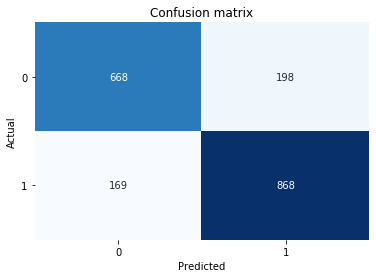

========= Eperiment -  df_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-413
df_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       866
           1       0.81      0.85      0.83      1037

    accuracy                           0.81      1903
   macro avg       0.81      0.80      0.81      1903
weighted avg       0.81      0.81      0.81      1903



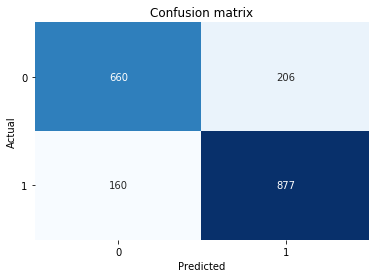

========= Eperiment -  df_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-414
df_B+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.74      0.57      0.64       866
           1       0.70      0.84      0.76      1037

    accuracy                           0.71      1903
   macro avg       0.72      0.70      0.70      1903
weighted avg       0.72      0.71      0.71      1903



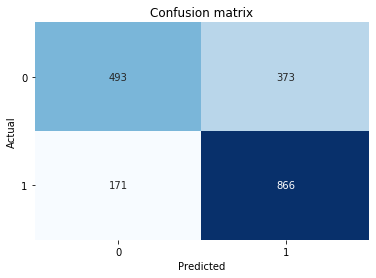

========= Eperiment -  df_B+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-415
df_B+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       866
           1       0.84      0.81      0.83      1037

    accuracy                           0.81      1903
   macro avg       0.81      0.81      0.81      1903
weighted avg       0.81      0.81      0.81      1903



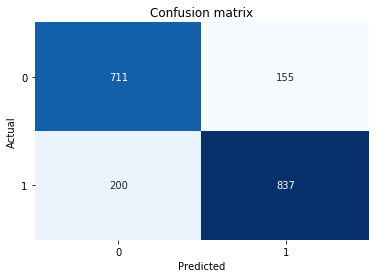

========= Eperiment -  df_B+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-416
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.807147,0.825487,0.837030,0.814259,0.804196
SVC linear,0.807672,0.827358,0.845709,0.809788,0.803917
NB,0.714136,0.760984,0.835101,0.698951,0.702193
RF,0.813452,0.825037,0.807136,0.843750,0.814076


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.832370,0.848312,0.860174,0.836773,0.829625
SVC linear+W2V skipgram,0.823437,0.841659,0.861138,0.823041,0.819714
NB+W2V skipgram,0.696795,0.747704,0.824494,0.684000,0.684187
RF+W2V skipgram,0.829217,0.839665,0.820636,0.859596,0.830064
LR+W2V CBOW,0.807147,0.825487,0.837030,0.814259,0.804196
SVC linear+W2V CBOW,0.807672,0.827358,0.845709,0.809788,0.803917
NB+W2V CBOW,0.714136,0.760984,0.835101,0.698951,0.702193
RF+W2V CBOW,0.813452,0.825037,0.807136,0.843750,0.814076


df_A_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2203
           1       0.79      0.70      0.74      1640

    accuracy                           0.79      3843
   macro avg       0.79      0.78      0.79      3843
weighted avg       0.79      0.79      0.79      3843



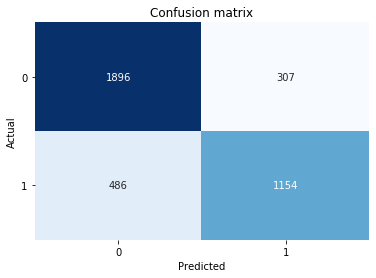

========= Eperiment -  df_A_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-417
df_A_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      2203
           1       0.79      0.70      0.74      1640

    accuracy                           0.79      3843
   macro avg       0.79      0.78      0.78      3843
weighted avg       0.79      0.79      0.79      3843



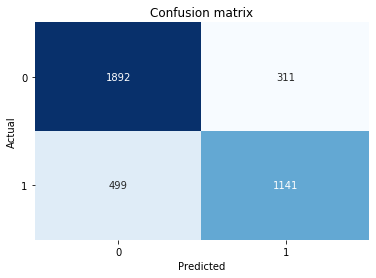

========= Eperiment -  df_A_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-418
df_A_B+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.78      0.51      0.62      2203
           1       0.55      0.80      0.65      1640

    accuracy                           0.64      3843
   macro avg       0.66      0.66      0.64      3843
weighted avg       0.68      0.64      0.63      3843



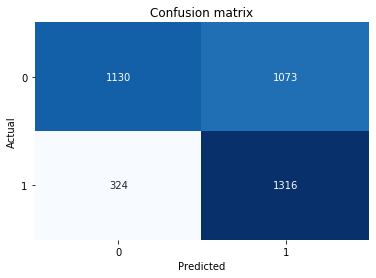

========= Eperiment -  df_A_B+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-419
df_A_B+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      2203
           1       0.86      0.66      0.75      1640

    accuracy                           0.81      3843
   macro avg       0.82      0.79      0.80      3843
weighted avg       0.82      0.81      0.80      3843



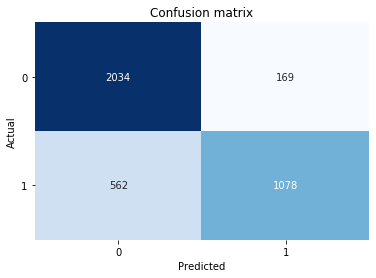

========= Eperiment -  df_A_B+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-420
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.793651,0.744276,0.703659,0.789870,0.782152
SVC linear,0.789227,0.738034,0.695732,0.785813,0.777280
NB,0.636482,0.653264,0.802439,0.550858,0.657688
RF,0.809784,0.746796,0.657317,0.864475,0.790302


df_A_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2203
           1       0.77      0.71      0.74      1640

    accuracy                           0.78      3843
   macro avg       0.78      0.78      0.78      3843
weighted avg       0.78      0.78      0.78      3843



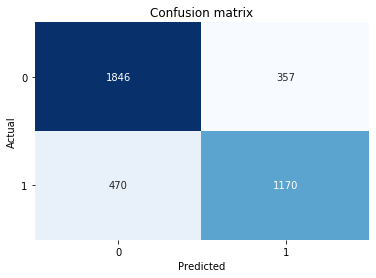

========= Eperiment -  df_A_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-421
df_A_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      2203
           1       0.76      0.71      0.74      1640

    accuracy                           0.78      3843
   macro avg       0.78      0.77      0.78      3843
weighted avg       0.78      0.78      0.78      3843



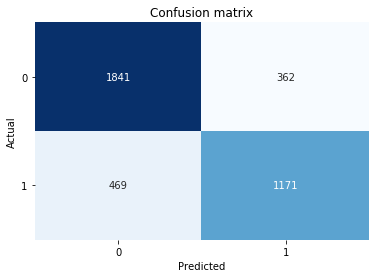

========= Eperiment -  df_A_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-422
df_A_B+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.75      0.50      0.60      2203
           1       0.54      0.78      0.64      1640

    accuracy                           0.62      3843
   macro avg       0.65      0.64      0.62      3843
weighted avg       0.66      0.62      0.62      3843



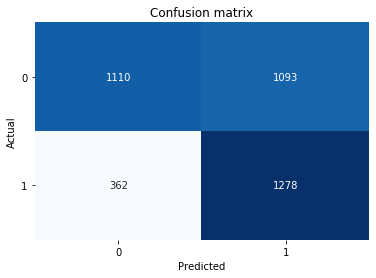

========= Eperiment -  df_A_B+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-423
df_A_B+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.76      0.91      0.83      2203
           1       0.83      0.61      0.71      1640

    accuracy                           0.78      3843
   macro avg       0.80      0.76      0.77      3843
weighted avg       0.79      0.78      0.78      3843



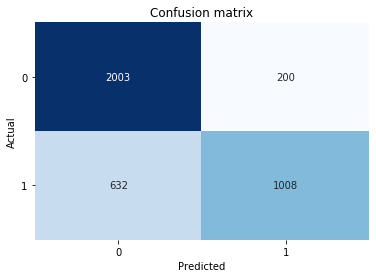

========= Eperiment -  df_A_B+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-424
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.784804,0.738870,0.713415,0.766208,0.775681
SVC linear,0.783763,0.738103,0.714024,0.763862,0.774852
NB,0.621390,0.637248,0.779268,0.539013,0.641563
RF,0.783502,0.707865,0.614634,0.834437,0.761924


 ====  df_A_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.793651,0.744276,0.703659,0.789870,0.782152
SVC linear+W2V skipgram,0.789227,0.738034,0.695732,0.785813,0.777280
NB+W2V skipgram,0.636482,0.653264,0.802439,0.550858,0.657688
RF+W2V skipgram,0.809784,0.746796,0.657317,0.864475,0.790302
LR+W2V CBOW,0.784804,0.738870,0.713415,0.766208,0.775681
SVC linear+W2V CBOW,0.783763,0.738103,0.714024,0.763862,0.774852
NB+W2V CBOW,0.621390,0.637248,0.779268,0.539013,0.641563
RF+W2V CBOW,0.783502,0.707865,0.614634,0.834437,0.761924


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+LR,0.793814,0.632353,0.569536,0.710744,0.732373
df_A+W2V skipgram+SVC linear,0.791753,0.635379,0.582781,0.698413,0.734505
df_A+W2V skipgram+NB,0.578351,0.547566,0.819536,0.411130,0.644424
df_A+W2V skipgram+RF,0.789691,0.554585,0.420530,0.814103,0.688558
df_A+W2V CBOW+LR,0.782474,0.607076,0.539735,0.693617,0.715975
df_A+W2V CBOW+SVC linear,0.779381,0.598499,0.528146,0.690476,0.710555
df_A+W2V CBOW+NB,0.569588,0.537396,0.802980,0.403830,0.633526
df_A+W2V CBOW+RF,0.775773,0.497110,0.355960,0.823755,0.660765
df_B+W2V skipgram+LR,0.832370,0.848312,0.860174,0.836773,0.829625
df_B+W2V skipgram+SVC linear,0.823437,0.841659,0.861138,0.823041,0.819714


Unexpected HTTP error in hardware metric reporting thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\neptune\utils.py", line 271, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\neptune\internal\api_clients\hosted_api_clients\hosted_alpha_leaderboard_api_client.py", line 632, in _execute_operations
    result = self.leaderboard_swagger_client.api.executeOperations(**kwargs).response().result
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\bravado\http_future.py", line 239, in response
    six.reraise(*sys.exc_info())
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\six.py", line 703, in reraise
    raise value
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\bravado\http_future.py", line 200, in response
    swagger_result = self._get_swagger_result(incoming_response)
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\bravado\http_future.py", line 124, in wrapper
    retu

In [21]:
df_dict = {'df_A':df_A,'df_B': df_B,'df_A_B' :df_A_B}
# feature dict
feature_dict={'W2V skipgram':word2vec_skipgram_embedding,'W2V CBOW':word2vec_cbow_embedding}
# model dict
model_dict = {"LR":utills.lr,"SVC linear":utills.svc_linear,"NB":utills.NB,"RF":utills.RF}
classifier_feature(df_dict, model_dict, feature_dict)

## Evaluate

In [15]:
df_dict = {'df_A':df_A,'df_B': df_B,'df_A_B' :df_A_B}
# feature dict
feature_dict={'W2V skipgram':word2vec_skipgram_embedding,'W2V CBOW':word2vec_cbow_embedding}
# model dict
model_dict = {"LR":utills.lr,"SVC linear":utills.svc_linear,"NB":utills.NB,"RF":utills.RF}


seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer longer suffix-
df_A+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1337
           1       0.64      0.17      0.27       604

    accuracy                           0.71      1941
   macro avg       0.68      0.56      0.54      1941
weighted avg       0.69      0.71      0.65      1941



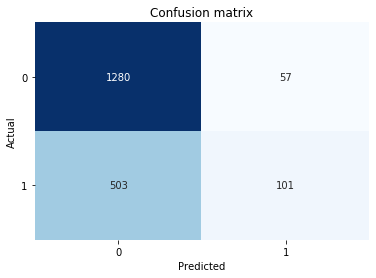

========= Eperiment -  df_A+W2V skipgram+LR  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-259
df_A+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1337
           1       0.79      0.05      0.09       604

    accuracy                           0.70      1941
   macro avg       0.74      0.52      0.46      1941
weighted avg       0.73      0.70      0.59      1941



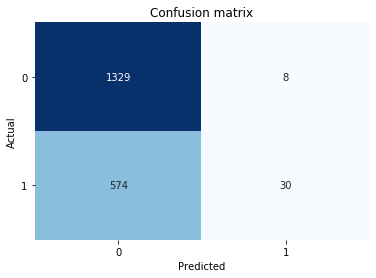

========= Eperiment -  df_A+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-260
df_A+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.81      0.35      0.49      1337
           1       0.36      0.81      0.50       604

    accuracy                           0.50      1941
   macro avg       0.59      0.58      0.50      1941
weighted avg       0.67      0.50      0.50      1941



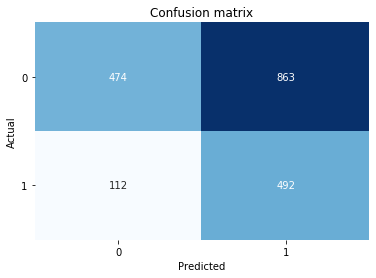

========= Eperiment -  df_A+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-261
df_A+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      1337
           1       0.69      0.17      0.27       604

    accuracy                           0.72      1941
   macro avg       0.71      0.57      0.55      1941
weighted avg       0.71      0.72      0.65      1941



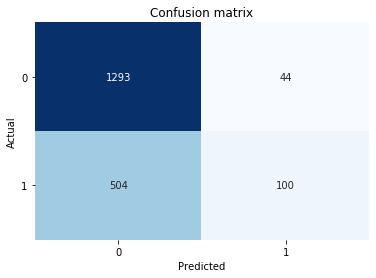

========= Eperiment -  df_A+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-262
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.711489,0.265092,0.167219,0.639241,0.562293
SVC linear,0.700155,0.093458,0.049669,0.789474,0.521843
NB,0.497682,0.502297,0.814570,0.363100,0.584547
RF,0.717671,0.267380,0.165563,0.694444,0.566327


df_A+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1337
           1       0.62      0.24      0.35       604

    accuracy                           0.72      1941
   macro avg       0.68      0.59      0.58      1941
weighted avg       0.70      0.72      0.67      1941



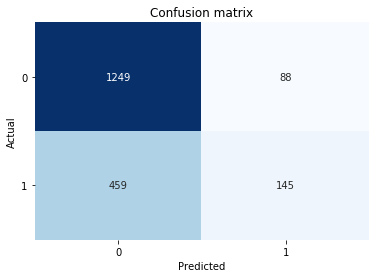

========= Eperiment -  df_A+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-263
df_A+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1337
           1       0.73      0.08      0.14       604

    accuracy                           0.70      1941
   macro avg       0.72      0.53      0.48      1941
weighted avg       0.71      0.70      0.61      1941



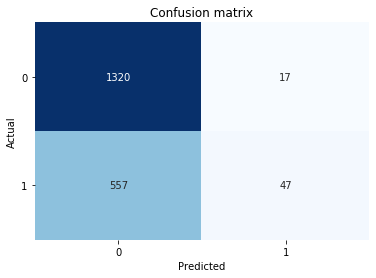

========= Eperiment -  df_A+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-264
df_A+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.79      0.35      0.49      1337
           1       0.35      0.79      0.49       604

    accuracy                           0.49      1941
   macro avg       0.57      0.57      0.49      1941
weighted avg       0.65      0.49      0.49      1941



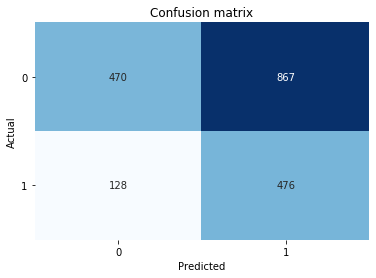

========= Eperiment -  df_A+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-265
df_A+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.72      0.96      0.83      1337
           1       0.69      0.18      0.28       604

    accuracy                           0.72      1941
   macro avg       0.71      0.57      0.55      1941
weighted avg       0.71      0.72      0.66      1941



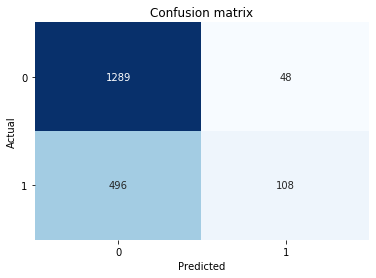

========= Eperiment -  df_A+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-266
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.718187,0.346476,0.240066,0.622318,0.587124
SVC linear,0.704276,0.140719,0.077815,0.734375,0.532550
NB,0.487378,0.488957,0.788079,0.354430,0.569806
RF,0.719732,0.284211,0.178808,0.692308,0.571453


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.711489,0.265092,0.167219,0.639241,0.562293
SVC linear+W2V skipgram,0.700155,0.093458,0.049669,0.789474,0.521843
NB+W2V skipgram,0.497682,0.502297,0.814570,0.363100,0.584547
RF+W2V skipgram,0.717671,0.267380,0.165563,0.694444,0.566327
LR+W2V CBOW,0.718187,0.346476,0.240066,0.622318,0.587124
SVC linear+W2V CBOW,0.704276,0.140719,0.077815,0.734375,0.532550
NB+W2V CBOW,0.487378,0.488957,0.788079,0.354430,0.569806
RF+W2V CBOW,0.719732,0.284211,0.178808,0.692308,0.571453


seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer longer suffix-
df_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       867
           1       0.70      0.79      0.75      1037

    accuracy                           0.71      1904
   macro avg       0.71      0.70      0.70      1904
weighted avg       0.71      0.71      0.70      1904



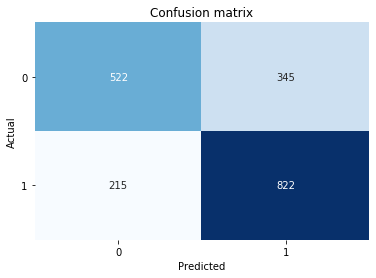

========= Eperiment -  df_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-267
df_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.71      0.59      0.65       867
           1       0.70      0.80      0.75      1037

    accuracy                           0.70      1904
   macro avg       0.71      0.70      0.70      1904
weighted avg       0.70      0.70      0.70      1904



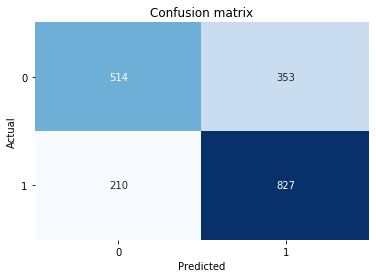

========= Eperiment -  df_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-268
df_B+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.62      0.39      0.48       867
           1       0.61      0.80      0.69      1037

    accuracy                           0.62      1904
   macro avg       0.62      0.60      0.59      1904
weighted avg       0.62      0.62      0.60      1904



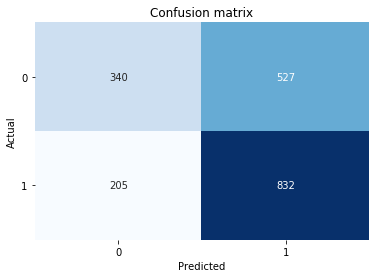

========= Eperiment -  df_B+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-269
df_B+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       867
           1       0.74      0.74      0.74      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.72      0.72      1904
weighted avg       0.72      0.72      0.72      1904



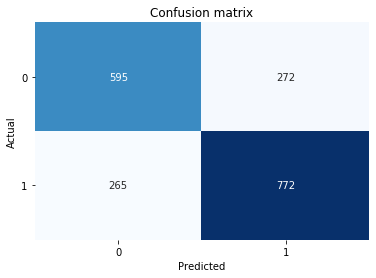

========= Eperiment -  df_B+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-270
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.705882,0.745917,0.792671,0.704370,0.697374
SVC linear,0.704307,0.746053,0.797493,0.700847,0.695171
NB,0.615546,0.694491,0.802314,0.612215,0.597236
RF,0.717962,0.741951,0.744455,0.739464,0.715365


df_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       867
           1       0.71      0.76      0.74      1037

    accuracy                           0.71      1904
   macro avg       0.70      0.70      0.70      1904
weighted avg       0.70      0.71      0.70      1904



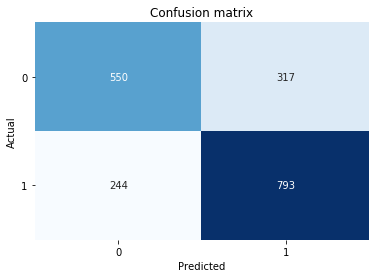

========= Eperiment -  df_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-271
df_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.61      0.65       867
           1       0.71      0.78      0.74      1037

    accuracy                           0.70      1904
   macro avg       0.70      0.70      0.70      1904
weighted avg       0.70      0.70      0.70      1904



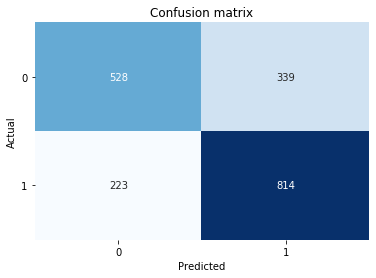

========= Eperiment -  df_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-272
df_B+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.64      0.41      0.50       867
           1       0.62      0.80      0.70      1037

    accuracy                           0.62      1904
   macro avg       0.63      0.61      0.60      1904
weighted avg       0.63      0.62      0.61      1904



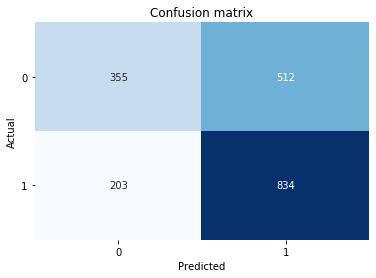

========= Eperiment -  df_B+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-273
df_B+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       867
           1       0.75      0.75      0.75      1037

    accuracy                           0.73      1904
   macro avg       0.73      0.73      0.73      1904
weighted avg       0.73      0.73      0.73      1904



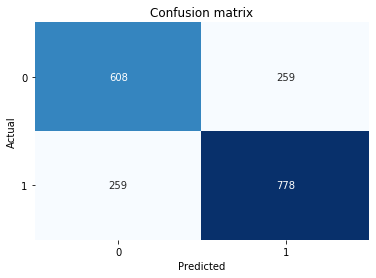

========= Eperiment -  df_B+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-274
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.705357,0.738705,0.764706,0.714414,0.699539
SVC linear,0.704832,0.743379,0.784957,0.705984,0.696977
NB,0.624475,0.699958,0.804243,0.619614,0.606850
RF,0.727941,0.750241,0.750241,0.750241,0.725755


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.705882,0.745917,0.792671,0.704370,0.697374
SVC linear+W2V skipgram,0.704307,0.746053,0.797493,0.700847,0.695171
NB+W2V skipgram,0.615546,0.694491,0.802314,0.612215,0.597236
RF+W2V skipgram,0.717962,0.741951,0.744455,0.739464,0.715365
LR+W2V CBOW,0.705357,0.738705,0.764706,0.714414,0.699539
SVC linear+W2V CBOW,0.704832,0.743379,0.784957,0.705984,0.696977
NB+W2V CBOW,0.624475,0.699958,0.804243,0.619614,0.606850
RF+W2V CBOW,0.727941,0.750241,0.750241,0.750241,0.725755


seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer longer suffix-
df_A_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      2204
           1       0.66      0.54      0.59      1640

    accuracy                           0.68      3844
   macro avg       0.68      0.66      0.67      3844
weighted avg       0.68      0.68      0.68      3844



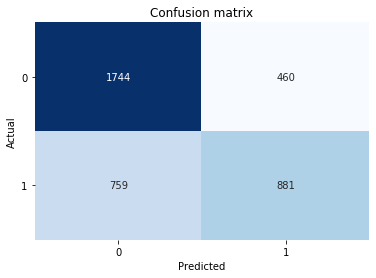

========= Eperiment -  df_A_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-275
df_A_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.79      0.74      2204
           1       0.66      0.54      0.59      1640

    accuracy                           0.68      3844
   macro avg       0.68      0.66      0.67      3844
weighted avg       0.68      0.68      0.68      3844



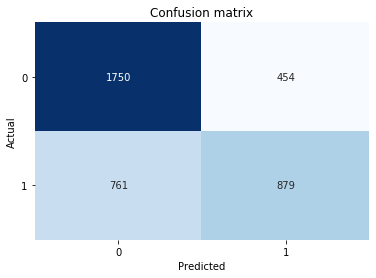

========= Eperiment -  df_A_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-276
df_A_B+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.67      0.34      0.45      2204
           1       0.47      0.77      0.58      1640

    accuracy                           0.53      3844
   macro avg       0.57      0.56      0.52      3844
weighted avg       0.58      0.53      0.51      3844



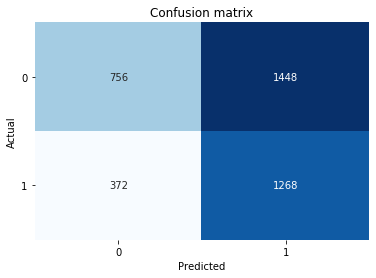

========= Eperiment -  df_A_B+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-277
df_A_B+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.68      0.84      0.75      2204
           1       0.68      0.46      0.55      1640

    accuracy                           0.68      3844
   macro avg       0.68      0.65      0.65      3844
weighted avg       0.68      0.68      0.66      3844



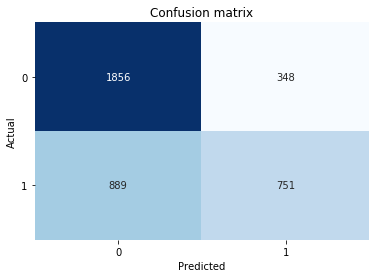

========= Eperiment -  df_A_B+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-278
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.682882,0.591077,0.537195,0.656972,0.664242
SVC linear,0.683923,0.591322,0.535976,0.659415,0.664993
NB,0.526535,0.582185,0.773171,0.466863,0.558092
RF,0.678200,0.548375,0.457927,0.683348,0.650016


df_A_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      2204
           1       0.65      0.58      0.61      1640

    accuracy                           0.69      3844
   macro avg       0.68      0.67      0.67      3844
weighted avg       0.68      0.69      0.68      3844



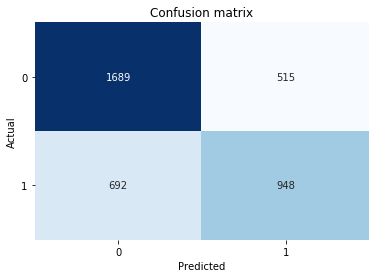

========= Eperiment -  df_A_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-279
df_A_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2204
           1       0.64      0.57      0.60      1640

    accuracy                           0.68      3844
   macro avg       0.67      0.66      0.67      3844
weighted avg       0.67      0.68      0.67      3844



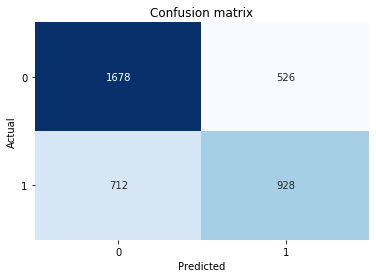

========= Eperiment -  df_A_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-280
df_A_B+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.67      0.35      0.46      2204
           1       0.47      0.77      0.58      1640

    accuracy                           0.53      3844
   macro avg       0.57      0.56      0.52      3844
weighted avg       0.58      0.53      0.51      3844



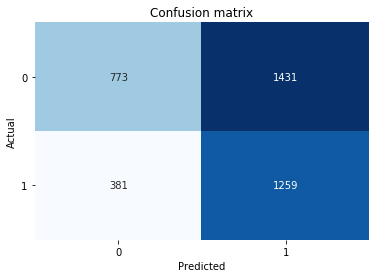

========= Eperiment -  df_A_B+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-281
df_A_B+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.69      0.83      0.75      2204
           1       0.69      0.48      0.57      1640

    accuracy                           0.69      3844
   macro avg       0.69      0.66      0.66      3844
weighted avg       0.69      0.69      0.67      3844



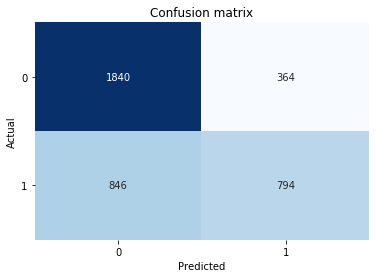

========= Eperiment -  df_A_B+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-282
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.686004,0.611022,0.578049,0.647984,0.672191
SVC linear,0.677940,0.599871,0.565854,0.638239,0.663598
NB,0.528616,0.581524,0.767683,0.468030,0.559204
RF,0.685224,0.567548,0.484146,0.685665,0.659496


 ====  df_A_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.682882,0.591077,0.537195,0.656972,0.664242
SVC linear+W2V skipgram,0.683923,0.591322,0.535976,0.659415,0.664993
NB+W2V skipgram,0.526535,0.582185,0.773171,0.466863,0.558092
RF+W2V skipgram,0.678200,0.548375,0.457927,0.683348,0.650016
LR+W2V CBOW,0.686004,0.611022,0.578049,0.647984,0.672191
SVC linear+W2V CBOW,0.677940,0.599871,0.565854,0.638239,0.663598
NB+W2V CBOW,0.528616,0.581524,0.767683,0.468030,0.559204
RF+W2V CBOW,0.685224,0.567548,0.484146,0.685665,0.659496


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+LR,0.711489,0.265092,0.167219,0.639241,0.562293
df_A+W2V skipgram+SVC linear,0.700155,0.093458,0.049669,0.789474,0.521843
df_A+W2V skipgram+NB,0.497682,0.502297,0.814570,0.363100,0.584547
df_A+W2V skipgram+RF,0.717671,0.267380,0.165563,0.694444,0.566327
df_A+W2V CBOW+LR,0.718187,0.346476,0.240066,0.622318,0.587124
df_A+W2V CBOW+SVC linear,0.704276,0.140719,0.077815,0.734375,0.532550
df_A+W2V CBOW+NB,0.487378,0.488957,0.788079,0.354430,0.569806
df_A+W2V CBOW+RF,0.719732,0.284211,0.178808,0.692308,0.571453
df_B+W2V skipgram+LR,0.705882,0.745917,0.792671,0.704370,0.697374
df_B+W2V skipgram+SVC linear,0.704307,0.746053,0.797493,0.700847,0.695171


In [16]:
classifier_feature(df_dict, model_dict, feature_dict)

## Test evaluaiton

In [78]:
def NB(X_train, X_test, Y_train):
    from sklearn.naive_bayes import GaussianNB
    nb = GaussianNB()
    nb = nb.fit(X_train, Y_train)
    Y_pred = nb.predict(X_test)
    Y_prob = nb.predict_proba(X_test)[:, 1]
    return Y_pred

# Random Forest


def RF(X_train, X_test, Y_train):
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, Y_train)
    Y_pred = rf.predict(X_test)
    Y_prob = rf.predict_proba(X_test)[:, 1]
    return Y_pred


df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
df_A+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1337
           1       0.65      0.16      0.26       604

    accuracy                           0.71      1941
   macro avg       0.68      0.56      0.54      1941
weighted avg       0.70      0.71      0.65      1941



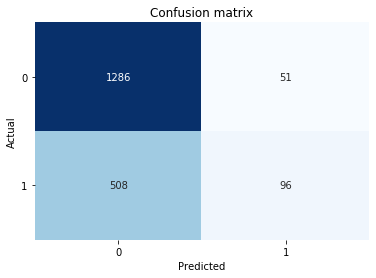

========= Eperiment -  df_A+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-209
df_A+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.79      0.29      0.42      1337
           1       0.35      0.83      0.49       604

    accuracy                           0.46      1941
   macro avg       0.57      0.56      0.46      1941
weighted avg       0.65      0.46      0.44      1941



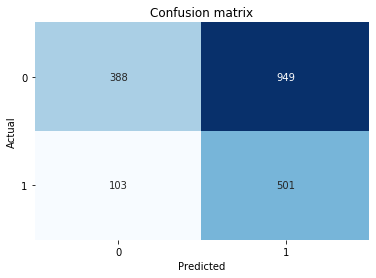

========= Eperiment -  df_A+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-210
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.712004,0.255659,0.15894,0.653061,0.560398
NB,0.458011,0.487829,0.82947,0.345517,0.559836


df_A+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.73      0.96      0.83      1337
           1       0.69      0.20      0.30       604

    accuracy                           0.72      1941
   macro avg       0.71      0.58      0.57      1941
weighted avg       0.72      0.72      0.66      1941



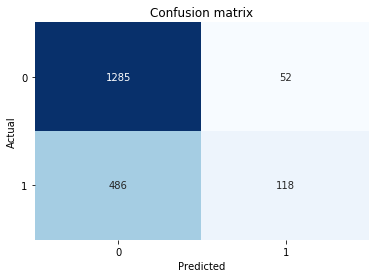

========= Eperiment -  df_A+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-211
df_A+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.78      0.37      0.50      1337
           1       0.36      0.77      0.49       604

    accuracy                           0.49      1941
   macro avg       0.57      0.57      0.49      1941
weighted avg       0.65      0.49      0.50      1941



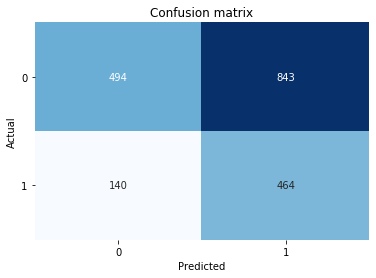

========= Eperiment -  df_A+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-212
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.722823,0.30491,0.195364,0.694118,0.578236
NB,0.493560,0.48561,0.768212,0.355011,0.568848


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF+W2V skipgram,0.712004,0.255659,0.158940,0.653061,0.560398
NB+W2V skipgram,0.458011,0.487829,0.829470,0.345517,0.559836
RF+W2V CBOW,0.722823,0.304910,0.195364,0.694118,0.578236
NB+W2V CBOW,0.493560,0.485610,0.768212,0.355011,0.568848


df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
df_B+W2V skipgram+RF
              precision    recall  f1-score   support

           0       0.70      0.70      0.70       867
           1       0.75      0.74      0.75      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.72      0.72      1904
weighted avg       0.72      0.72      0.72      1904



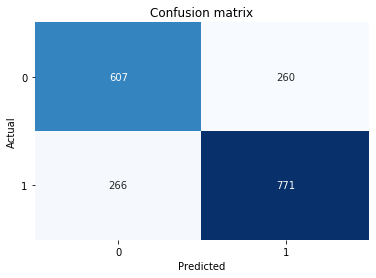

========= Eperiment -  df_B+W2V skipgram+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-213
df_B+W2V skipgram+NB
              precision    recall  f1-score   support

           0       0.64      0.37      0.47       867
           1       0.61      0.83      0.70      1037

    accuracy                           0.62      1904
   macro avg       0.62      0.60      0.58      1904
weighted avg       0.62      0.62      0.59      1904



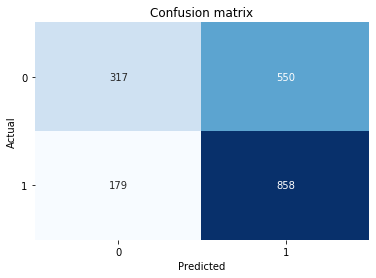

========= Eperiment -  df_B+W2V skipgram+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-214


Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 421, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 416, in _make_request
    httplib_response = conn.getresponse()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 1344, in getresponse
    response.begin()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 306, in begin
    version, status, reason = self._read_status()
  File "C:\Users\Kavishka\anaconda3\lib\http\client.py", line 267, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "C:\Users\Kavishka\anaconda3\lib\socket.py", line 589, in readinto
    return self._sock.recv_into

 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.723739,0.745648,0.743491,0.747818,0.721803
NB,0.617122,0.701840,0.827387,0.609375,0.596508


df_B+W2V CBOW+RF
              precision    recall  f1-score   support

           0       0.71      0.69      0.70       867
           1       0.75      0.76      0.76      1037

    accuracy                           0.73      1904
   macro avg       0.73      0.73      0.73      1904
weighted avg       0.73      0.73      0.73      1904



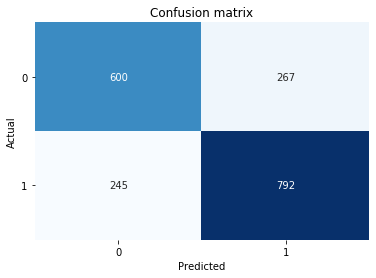

========= Eperiment -  df_B+W2V CBOW+RF  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-215
df_B+W2V CBOW+NB
              precision    recall  f1-score   support

           0       0.65      0.42      0.51       867
           1       0.63      0.81      0.71      1037

    accuracy                           0.63      1904
   macro avg       0.64      0.62      0.61      1904
weighted avg       0.64      0.63      0.62      1904



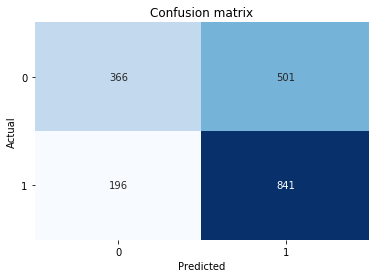

========= Eperiment -  df_B+W2V CBOW+NB  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-216
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF,0.731092,0.755725,0.763742,0.747875,0.727892
NB,0.633929,0.707020,0.810993,0.626677,0.616569


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
RF+W2V skipgram,0.723739,0.745648,0.743491,0.747818,0.721803
NB+W2V skipgram,0.617122,0.701840,0.827387,0.609375,0.596508
RF+W2V CBOW,0.731092,0.755725,0.763742,0.747875,0.727892
NB+W2V CBOW,0.633929,0.707020,0.810993,0.626677,0.616569


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+RF,0.712004,0.255659,0.158940,0.653061,0.560398
df_A+W2V skipgram+NB,0.458011,0.487829,0.829470,0.345517,0.559836
df_A+W2V CBOW+RF,0.722823,0.304910,0.195364,0.694118,0.578236
df_A+W2V CBOW+NB,0.493560,0.485610,0.768212,0.355011,0.568848
df_B+W2V skipgram+RF,0.723739,0.745648,0.743491,0.747818,0.721803
df_B+W2V skipgram+NB,0.617122,0.701840,0.827387,0.609375,0.596508
df_B+W2V CBOW+RF,0.731092,0.755725,0.763742,0.747875,0.727892
df_B+W2V CBOW+NB,0.633929,0.707020,0.810993,0.626677,0.616569


In [80]:
classifier_feature({'df_A':df_A,'df_B':df_B}, {'RF':RF,'NB':NB}, {'W2V skipgram':word2vec_skipgram_embedding,'W2V CBOW':word2vec_cbow_embedding})

## Visualization of tsne

In [71]:
def tsne_plot(model):
    from sklearn.manifold import TSNE
    "Create TSNE model and plot it"
    labels = []
    tokens = []

    for word in model.index_to_key:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(18, 18)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()
   

In [ ]:
tsne_plot(model_cbow.wv)

## fine tuned pretrained one

In [ ]:
new_model.build_vocab(df_A.comment.values, update = True)
new_model.train(df_A.comment.values, total_examples=2, epochs = 1)
new_model.wv.vocab

## How stemming affect the word embedding

In [82]:
print(model.wv.most_similar('සිසුන'))
print(model.wv.most_similar('සිස'))
print(model.wv.most_similar('සිසුන'))
print(model.wv.most_similar('නොමැ'))  # නොමැති
print(model.wv.most_similar('නොමැති'))

[('්පොරෝජනයට', 0.7376485466957092), ('ක්\u200dරියාපිළිවෙතකි', 0.7028831243515015), ('\u200dසරසවි', 0.7002137899398804), ('බයින්ගෙන්', 0.6858236193656921), ('අටසහසකට', 0.658367395401001), ('වෘත්තීයවේදිනියන්', 0.6538061499595642), ('සිසුවියන්ය', 0.6532202959060669), ('සුසුවියන්', 0.6531831622123718), ('හැදැරූවන්ද', 0.6509316563606262), ('ශාස්ත\u200d්\u200dරපීඨ', 0.6508955359458923)]
[('ඊට්ටිකුල', 0.5869222283363342), ('විශේෂඥයාවරයාගේ', 0.5849105715751648), ('බෙකර්ලි', 0.574848473072052), ('ගුරුවරියෙක්මි', 0.5744667649269104), ('සටනේ\tකොළඹ', 0.5734717845916748), ('සිසසුන්ගෙ', 0.570600688457489), ('ජීක්ල්', 0.5696278214454651), ('ඒ.එෆ්', 0.5689621567726135), ('ඉංජිනේරුවිද්\u200dයා', 0.5683059096336365), ('ලැට්ටෝවෛද්\u200dය', 0.5654928684234619)]
[('්පොරෝජනයට', 0.7376485466957092), ('ක්\u200dරියාපිළිවෙතකි', 0.7028831243515015), ('\u200dසරසවි', 0.7002137899398804), ('බයින්ගෙන්', 0.6858236193656921), ('අටසහසකට', 0.658367395401001), ('වෘත්තීයවේදිනියන්', 0.6538061499595642), ('සිසුවියන්ය', 0.

# Shorter stemmer or longer stemmer or no stemming

## wihtout stemming

df_A 6468
X train (4527,) Y train (4527,) X test (1941,) Y test (1941,)
df_A+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.71      0.96      0.81      1337
           1       0.58      0.12      0.20       604

    accuracy                           0.70      1941
   macro avg       0.64      0.54      0.51      1941
weighted avg       0.67      0.70      0.62      1941



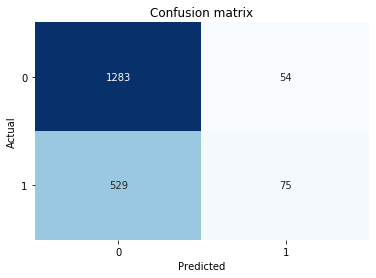

========= Eperiment -  df_A+W2V skipgram+LR  =========


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-217
df_A+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       0.80      0.02      0.04       604

    accuracy                           0.69      1941
   macro avg       0.75      0.51      0.43      1941
weighted avg       0.73      0.69      0.58      1941



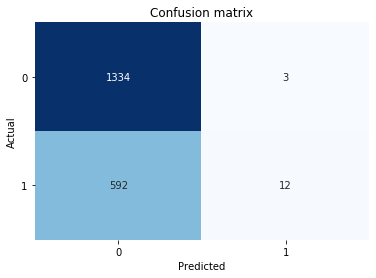

========= Eperiment -  df_A+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-218
df_A+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       1.00      0.00      0.00       604

    accuracy                           0.69      1941
   macro avg       0.84      0.50      0.41      1941
weighted avg       0.79      0.69      0.56      1941



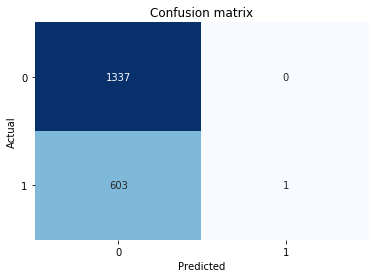

========= Eperiment -  df_A+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-219
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.699639,0.204638,0.124172,0.581395,0.541892
SVC linear,0.693457,0.038772,0.019868,0.800000,0.508812
SVC rbf,0.689335,0.003306,0.001656,1.000000,0.500828


df_A+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.72      0.94      0.81      1337
           1       0.56      0.17      0.27       604

    accuracy                           0.70      1941
   macro avg       0.64      0.56      0.54      1941
weighted avg       0.67      0.70      0.64      1941



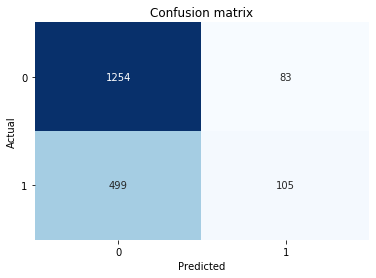

========= Eperiment -  df_A+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-220
df_A+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1337
           1       0.64      0.04      0.08       604

    accuracy                           0.70      1941
   macro avg       0.67      0.52      0.45      1941
weighted avg       0.68      0.70      0.59      1941



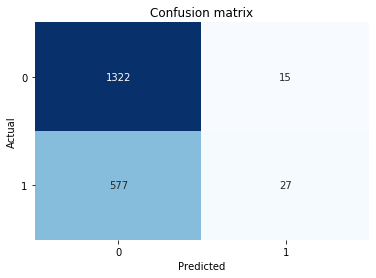

========= Eperiment -  df_A+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-221
df_A+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       0.00      0.00      0.00       604

    accuracy                           0.69      1941
   macro avg       0.34      0.50      0.41      1941
weighted avg       0.47      0.69      0.56      1941



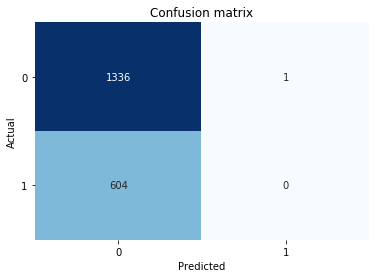

========= Eperiment -  df_A+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-222
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.700155,0.265152,0.173841,0.558511,0.555881
SVC linear,0.695003,0.083591,0.044702,0.642857,0.516741
SVC rbf,0.688305,0.000000,0.000000,0.000000,0.499626


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.699639,0.204638,0.124172,0.581395,0.541892
SVC linear+W2V skipgram,0.693457,0.038772,0.019868,0.800000,0.508812
SVC rbf+W2V skipgram,0.689335,0.003306,0.001656,1.000000,0.500828
LR+W2V CBOW,0.700155,0.265152,0.173841,0.558511,0.555881
SVC linear+W2V CBOW,0.695003,0.083591,0.044702,0.642857,0.516741
SVC rbf+W2V CBOW,0.688305,0.000000,0.000000,0.000000,0.499626


df_B 6345
X train (4441,) Y train (4441,) X test (1904,) Y test (1904,)
df_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.72      0.61      0.66       867
           1       0.71      0.80      0.75      1037

    accuracy                           0.71      1904
   macro avg       0.71      0.70      0.71      1904
weighted avg       0.71      0.71      0.71      1904



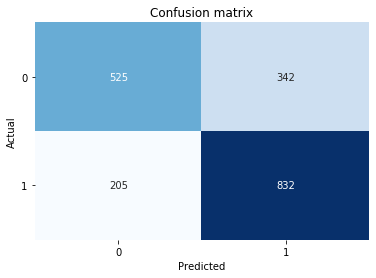

========= Eperiment -  df_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-223
df_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.73      0.59      0.66       867
           1       0.71      0.82      0.76      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.71      0.71      1904
weighted avg       0.72      0.72      0.71      1904



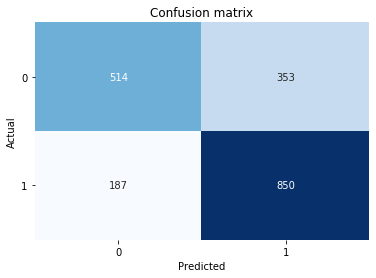

========= Eperiment -  df_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-224
df_B+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.75      0.55      0.63       867
           1       0.69      0.85      0.76      1037

    accuracy                           0.71      1904
   macro avg       0.72      0.70      0.70      1904
weighted avg       0.72      0.71      0.70      1904



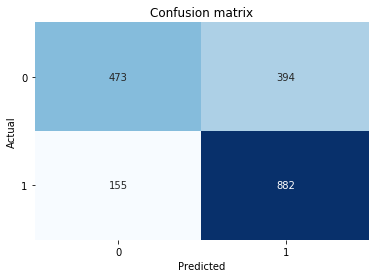

========= Eperiment -  df_B+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-225
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.712710,0.752601,0.802314,0.708688,0.703925
SVC linear,0.716387,0.758929,0.819672,0.706567,0.706261
SVC rbf,0.711660,0.762646,0.850530,0.691223,0.698045


df_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.71      0.64      0.68       867
           1       0.72      0.78      0.75      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.71      0.71      1904
weighted avg       0.72      0.72      0.72      1904



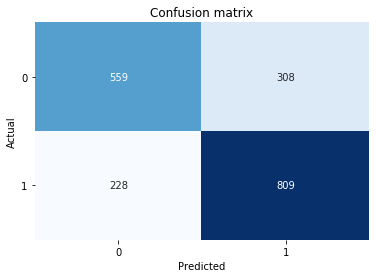

========= Eperiment -  df_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-226
df_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       867
           1       0.72      0.80      0.76      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.72      0.72      1904
weighted avg       0.72      0.72      0.72      1904



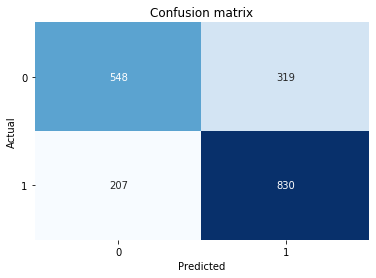

========= Eperiment -  df_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-227
df_B+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.77      0.59      0.67       867
           1       0.71      0.85      0.78      1037

    accuracy                           0.73      1904
   macro avg       0.74      0.72      0.72      1904
weighted avg       0.74      0.73      0.73      1904



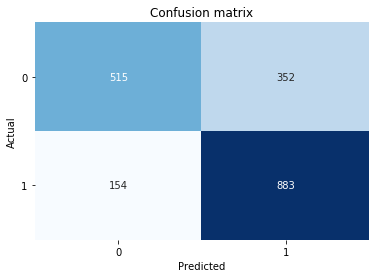

========= Eperiment -  df_B+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-228
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.718487,0.751161,0.780135,0.724261,0.712444
SVC linear,0.723739,0.759378,0.800386,0.722367,0.716225
SVC rbf,0.734244,0.777289,0.851495,0.714980,0.722749


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.712710,0.752601,0.802314,0.708688,0.703925
SVC linear+W2V skipgram,0.716387,0.758929,0.819672,0.706567,0.706261
SVC rbf+W2V skipgram,0.711660,0.762646,0.850530,0.691223,0.698045
LR+W2V CBOW,0.718487,0.751161,0.780135,0.724261,0.712444
SVC linear+W2V CBOW,0.723739,0.759378,0.800386,0.722367,0.716225
SVC rbf+W2V CBOW,0.734244,0.777289,0.851495,0.714980,0.722749


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+LR,0.699639,0.204638,0.124172,0.581395,0.541892
df_A+W2V skipgram+SVC linear,0.693457,0.038772,0.019868,0.800000,0.508812
df_A+W2V skipgram+SVC rbf,0.689335,0.003306,0.001656,1.000000,0.500828
df_A+W2V CBOW+LR,0.700155,0.265152,0.173841,0.558511,0.555881
df_A+W2V CBOW+SVC linear,0.695003,0.083591,0.044702,0.642857,0.516741
df_A+W2V CBOW+SVC rbf,0.688305,0.000000,0.000000,0.000000,0.499626
df_B+W2V skipgram+LR,0.712710,0.752601,0.802314,0.708688,0.703925
df_B+W2V skipgram+SVC linear,0.716387,0.758929,0.819672,0.706567,0.706261
df_B+W2V skipgram+SVC rbf,0.711660,0.762646,0.850530,0.691223,0.698045
df_B+W2V CBOW+LR,0.718487,0.751161,0.780135,0.724261,0.712444


In [17]:
## no stemming -> changing classifeir feature to use prepare_dataset function
classifier_feature({'df_A':df_A,'df_B':df_B}, model_dict, feature_dict)

## Stemmig shorter suffix

seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer shorter suffix-
df_A+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.71      0.96      0.82      1337
           1       0.62      0.15      0.24       604

    accuracy                           0.71      1941
   macro avg       0.67      0.55      0.53      1941
weighted avg       0.68      0.71      0.64      1941



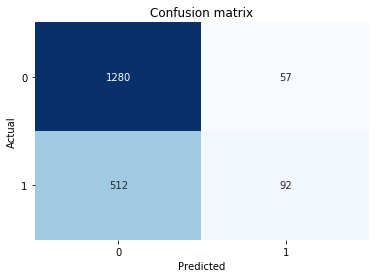

========= Eperiment -  df_A+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-229
df_A+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.69      0.99      0.82      1337
           1       0.71      0.03      0.06       604

    accuracy                           0.70      1941
   macro avg       0.70      0.51      0.44      1941
weighted avg       0.70      0.70      0.58      1941



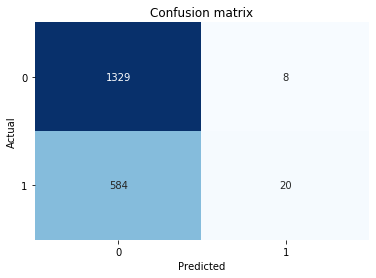

========= Eperiment -  df_A+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-230
df_A+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       0.50      0.00      0.01       604

    accuracy                           0.69      1941
   macro avg       0.59      0.50      0.41      1941
weighted avg       0.63      0.69      0.56      1941



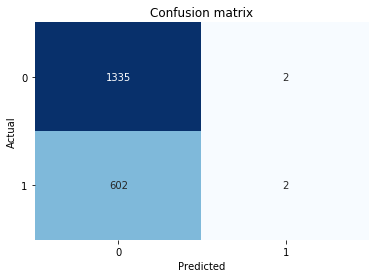

========= Eperiment -  df_A+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-231
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.706852,0.244356,0.152318,0.617450,0.554843
SVC linear,0.695003,0.063291,0.033113,0.714286,0.513565
SVC rbf,0.688820,0.006579,0.003311,0.500000,0.500908


df_A+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.73      0.95      0.82      1337
           1       0.65      0.23      0.34       604

    accuracy                           0.72      1941
   macro avg       0.69      0.59      0.58      1941
weighted avg       0.71      0.72      0.67      1941



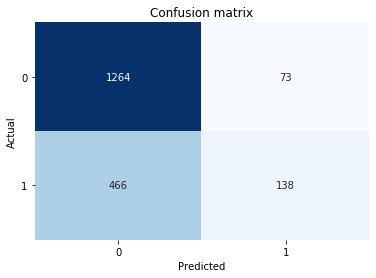

========= Eperiment -  df_A+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-232
df_A+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1337
           1       0.74      0.07      0.14       604

    accuracy                           0.70      1941
   macro avg       0.72      0.53      0.48      1941
weighted avg       0.71      0.70      0.61      1941



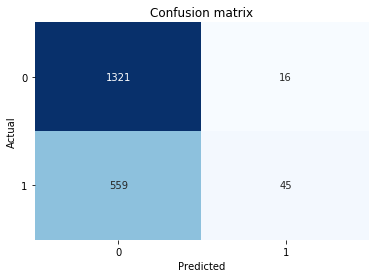

========= Eperiment -  df_A+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-233
df_A+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       0.50      0.00      0.00       604

    accuracy                           0.69      1941
   macro avg       0.59      0.50      0.41      1941
weighted avg       0.63      0.69      0.56      1941



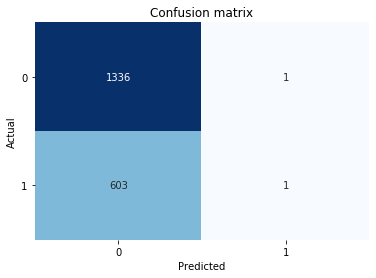

========= Eperiment -  df_A+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-234
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.722308,0.338650,0.228477,0.654028,0.586938
SVC linear,0.703761,0.135338,0.074503,0.737705,0.531268
SVC rbf,0.688820,0.003300,0.001656,0.500000,0.500454


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.706852,0.244356,0.152318,0.617450,0.554843
SVC linear+W2V skipgram,0.695003,0.063291,0.033113,0.714286,0.513565
SVC rbf+W2V skipgram,0.688820,0.006579,0.003311,0.500000,0.500908
LR+W2V CBOW,0.722308,0.338650,0.228477,0.654028,0.586938
SVC linear+W2V CBOW,0.703761,0.135338,0.074503,0.737705,0.531268
SVC rbf+W2V CBOW,0.688820,0.003300,0.001656,0.500000,0.500454


seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer shorter suffix-
df_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.70      0.59      0.64       867
           1       0.70      0.79      0.74      1037

    accuracy                           0.70      1904
   macro avg       0.70      0.69      0.69      1904
weighted avg       0.70      0.70      0.70      1904



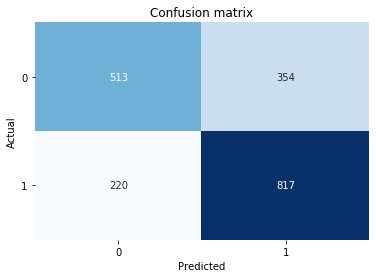

========= Eperiment -  df_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-235
df_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.58      0.63       867
           1       0.69      0.79      0.74      1037

    accuracy                           0.70      1904
   macro avg       0.70      0.69      0.69      1904
weighted avg       0.70      0.70      0.69      1904



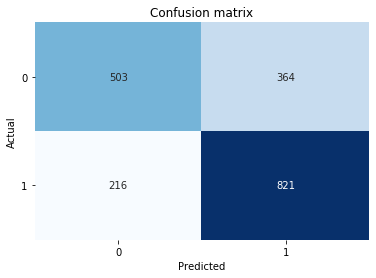

========= Eperiment -  df_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-236
df_B+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.74      0.53      0.62       867
           1       0.68      0.84      0.75      1037

    accuracy                           0.70      1904
   macro avg       0.71      0.69      0.68      1904
weighted avg       0.71      0.70      0.69      1904



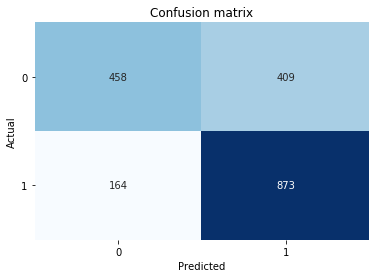

========= Eperiment -  df_B+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-237
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.698529,0.740036,0.787850,0.697694,0.689773
SVC linear,0.695378,0.738974,0.791707,0.692827,0.685934
SVC rbf,0.699055,0.752911,0.841851,0.680967,0.685055


df_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       867
           1       0.72      0.78      0.75      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.71      0.71      1904
weighted avg       0.72      0.72      0.71      1904



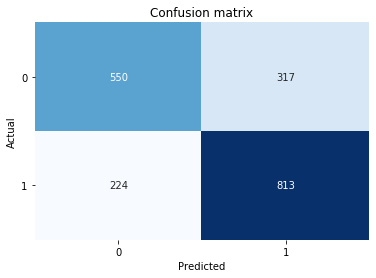

========= Eperiment -  df_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-238
df_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.73      0.62      0.67       867
           1       0.72      0.81      0.76      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.72      0.72      1904
weighted avg       0.72      0.72      0.72      1904



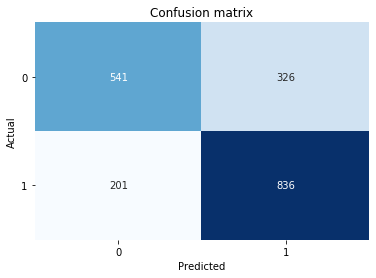

========= Eperiment -  df_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-239
df_B+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.77      0.57      0.65       867
           1       0.70      0.86      0.77      1037

    accuracy                           0.72      1904
   macro avg       0.74      0.71      0.71      1904
weighted avg       0.73      0.72      0.72      1904



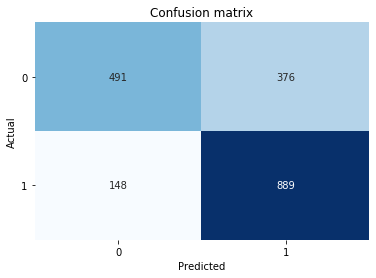

========= Eperiment -  df_B+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-240
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.715861,0.750346,0.783992,0.719469,0.709182
SVC linear,0.723214,0.760346,0.806172,0.719449,0.715081
SVC rbf,0.724790,0.772372,0.857281,0.702767,0.711801


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.698529,0.740036,0.787850,0.697694,0.689773
SVC linear+W2V skipgram,0.695378,0.738974,0.791707,0.692827,0.685934
SVC rbf+W2V skipgram,0.699055,0.752911,0.841851,0.680967,0.685055
LR+W2V CBOW,0.715861,0.750346,0.783992,0.719469,0.709182
SVC linear+W2V CBOW,0.723214,0.760346,0.806172,0.719449,0.715081
SVC rbf+W2V CBOW,0.724790,0.772372,0.857281,0.702767,0.711801


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+LR,0.706852,0.244356,0.152318,0.617450,0.554843
df_A+W2V skipgram+SVC linear,0.695003,0.063291,0.033113,0.714286,0.513565
df_A+W2V skipgram+SVC rbf,0.688820,0.006579,0.003311,0.500000,0.500908
df_A+W2V CBOW+LR,0.722308,0.338650,0.228477,0.654028,0.586938
df_A+W2V CBOW+SVC linear,0.703761,0.135338,0.074503,0.737705,0.531268
df_A+W2V CBOW+SVC rbf,0.688820,0.003300,0.001656,0.500000,0.500454
df_B+W2V skipgram+LR,0.698529,0.740036,0.787850,0.697694,0.689773
df_B+W2V skipgram+SVC linear,0.695378,0.738974,0.791707,0.692827,0.685934
df_B+W2V skipgram+SVC rbf,0.699055,0.752911,0.841851,0.680967,0.685055
df_B+W2V CBOW+LR,0.715861,0.750346,0.783992,0.719469,0.709182


In [26]:
## shorter stemmer -> change classifer feature to use preprocessor and flag
classifier_feature({'df_A':df_A,'df_B':df_B}, model_dict, feature_dict)

## stemming longer suffix

seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer longer suffix-
df_A+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.72      0.96      0.82      1337
           1       0.66      0.17      0.26       604

    accuracy                           0.71      1941
   macro avg       0.69      0.56      0.54      1941
weighted avg       0.70      0.71      0.65      1941



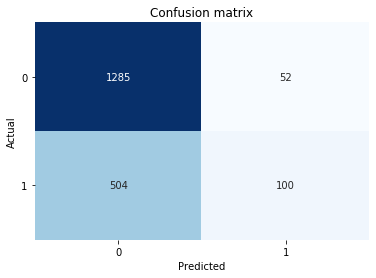

========= Eperiment -  df_A+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-241
df_A+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.99      0.82      1337
           1       0.78      0.06      0.11       604

    accuracy                           0.70      1941
   macro avg       0.74      0.53      0.46      1941
weighted avg       0.72      0.70      0.60      1941



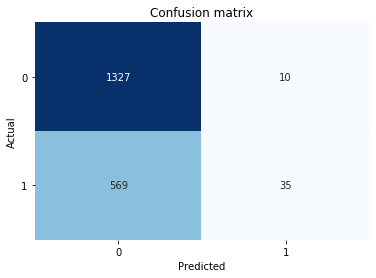

========= Eperiment -  df_A+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-242
df_A+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       0.60      0.00      0.01       604

    accuracy                           0.69      1941
   macro avg       0.64      0.50      0.41      1941
weighted avg       0.66      0.69      0.56      1941



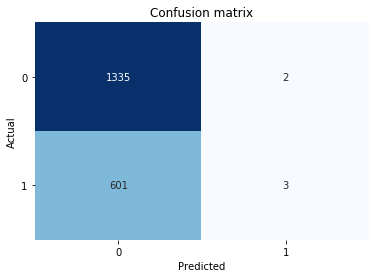

========= Eperiment -  df_A+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-243
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.713550,0.264550,0.165563,0.657895,0.563335
SVC linear,0.701700,0.107858,0.057947,0.777778,0.525234
SVC rbf,0.689335,0.009852,0.004967,0.600000,0.501736


df_A+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.73      0.93      0.82      1337
           1       0.60      0.24      0.35       604

    accuracy                           0.71      1941
   macro avg       0.66      0.58      0.58      1941
weighted avg       0.69      0.71      0.67      1941



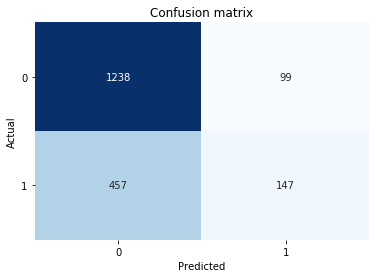

========= Eperiment -  df_A+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-244
df_A+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.71      0.99      0.82      1337
           1       0.75      0.09      0.16       604

    accuracy                           0.71      1941
   macro avg       0.73      0.54      0.49      1941
weighted avg       0.72      0.71      0.62      1941



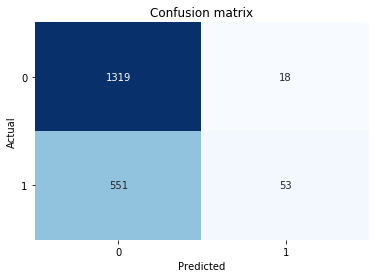

========= Eperiment -  df_A+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-245
df_A+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      1337
           1       0.75      0.00      0.01       604

    accuracy                           0.69      1941
   macro avg       0.72      0.50      0.41      1941
weighted avg       0.71      0.69      0.57      1941



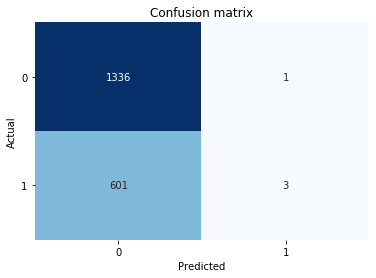

========= Eperiment -  df_A+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-246
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.713550,0.345882,0.243377,0.597561,0.584666
SVC linear,0.706852,0.157037,0.087748,0.746479,0.537143
SVC rbf,0.689851,0.009868,0.004967,0.750000,0.502109


 ====  df_A  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.713550,0.264550,0.165563,0.657895,0.563335
SVC linear+W2V skipgram,0.701700,0.107858,0.057947,0.777778,0.525234
SVC rbf+W2V skipgram,0.689335,0.009852,0.004967,0.600000,0.501736
LR+W2V CBOW,0.713550,0.345882,0.243377,0.597561,0.584666
SVC linear+W2V CBOW,0.706852,0.157037,0.087748,0.746479,0.537143
SVC rbf+W2V CBOW,0.689851,0.009868,0.004967,0.750000,0.502109


seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-
-custome stemmer longer suffix-
df_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.71      0.61      0.66       867
           1       0.71      0.79      0.75      1037

    accuracy                           0.71      1904
   macro avg       0.71      0.70      0.70      1904
weighted avg       0.71      0.71      0.71      1904



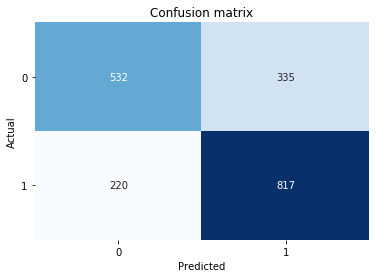

========= Eperiment -  df_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-247
df_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.71      0.60      0.65       867
           1       0.70      0.80      0.75      1037

    accuracy                           0.71      1904
   macro avg       0.71      0.70      0.70      1904
weighted avg       0.71      0.71      0.70      1904



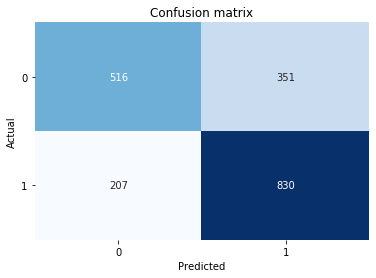

========= Eperiment -  df_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-248
df_B+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.72      0.55      0.62       867
           1       0.69      0.82      0.75      1037

    accuracy                           0.70      1904
   macro avg       0.70      0.69      0.68      1904
weighted avg       0.70      0.70      0.69      1904



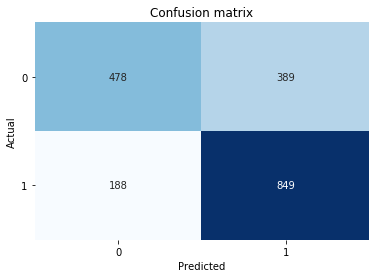

========= Eperiment -  df_B+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-249
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.708508,0.746460,0.787850,0.709201,0.700730
SVC linear,0.706933,0.748422,0.800386,0.702794,0.697771
SVC rbf,0.696954,0.746374,0.818708,0.685784,0.685017


df_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       867
           1       0.72      0.79      0.75      1037

    accuracy                           0.72      1904
   macro avg       0.72      0.71      0.71      1904
weighted avg       0.72      0.72      0.71      1904



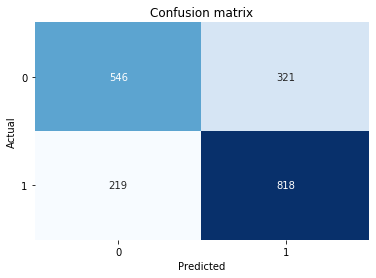

========= Eperiment -  df_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-250
df_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       867
           1       0.73      0.81      0.76      1037

    accuracy                           0.73      1904
   macro avg       0.73      0.72      0.72      1904
weighted avg       0.73      0.73      0.73      1904



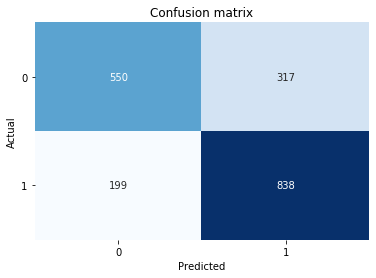

========= Eperiment -  df_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-251
df_B+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.75      0.56      0.64       867
           1       0.70      0.85      0.77      1037

    accuracy                           0.72      1904
   macro avg       0.73      0.70      0.70      1904
weighted avg       0.72      0.72      0.71      1904



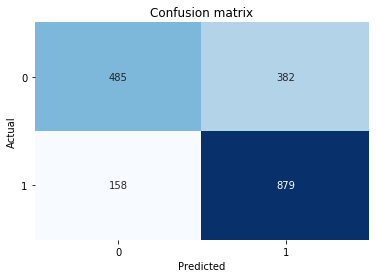

========= Eperiment -  df_B+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-252
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.716387,0.751838,0.788814,0.718174,0.709286
SVC linear,0.728992,0.764599,0.808100,0.725541,0.721236
SVC rbf,0.716387,0.765013,0.847637,0.697066,0.703519


 ====  df_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.708508,0.746460,0.787850,0.709201,0.700730
SVC linear+W2V skipgram,0.706933,0.748422,0.800386,0.702794,0.697771
SVC rbf+W2V skipgram,0.696954,0.746374,0.818708,0.685784,0.685017
LR+W2V CBOW,0.716387,0.751838,0.788814,0.718174,0.709286
SVC linear+W2V CBOW,0.728992,0.764599,0.808100,0.725541,0.721236
SVC rbf+W2V CBOW,0.716387,0.765013,0.847637,0.697066,0.703519


seperator
-url-
-mention-
-non_sinhala-
-special charactrer-
-puntuation-
-emoji remove-
-number-


Unexpected error in ping thread.
Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connection.py", line 157, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\util\connection.py", line 61, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
  File "C:\Users\Kavishka\anaconda3\lib\socket.py", line 752, in getaddrinfo
    for res in _socket.getaddrinfo(host, port, family, type, proto, flags):
socket.gaierror: [Errno 11001] getaddrinfo failed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 672, in urlopen
    chunked=chunked,
  File "C:\Users\Kavishka\anaconda3\lib\site-packages\urllib3\connectionpool.py", line 376, in _make_request
    self._validate_conn(conn)
  File "C:\Use

-custome stemmer longer suffix-
df_A_B+W2V skipgram+LR
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      2204
           1       0.64      0.52      0.58      1640

    accuracy                           0.67      3844
   macro avg       0.67      0.65      0.65      3844
weighted avg       0.67      0.67      0.67      3844



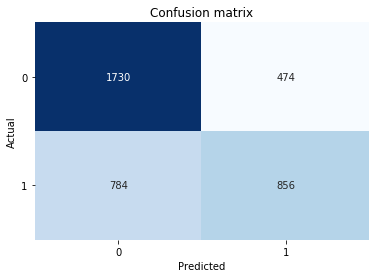

========= Eperiment -  df_A_B+W2V skipgram+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-253
df_A_B+W2V skipgram+SVC linear
              precision    recall  f1-score   support

           0       0.69      0.78      0.73      2204
           1       0.64      0.52      0.57      1640

    accuracy                           0.67      3844
   macro avg       0.66      0.65      0.65      3844
weighted avg       0.67      0.67      0.66      3844



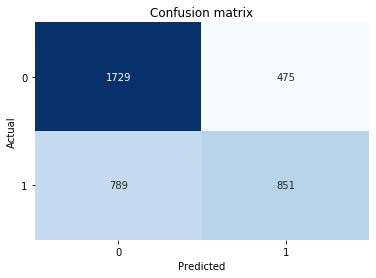

========= Eperiment -  df_A_B+W2V skipgram+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-254
df_A_B+W2V skipgram+SVC rbf
              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2204
           1       0.68      0.50      0.58      1640

    accuracy                           0.68      3844
   macro avg       0.68      0.66      0.66      3844
weighted avg       0.68      0.68      0.67      3844



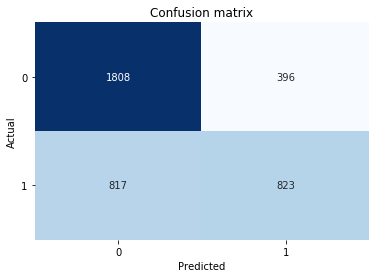

========= Eperiment -  df_A_B+W2V skipgram+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-255
 ====  W2V skipgram  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.672737,0.576431,0.521951,0.643609,0.653444
SVC linear,0.671176,0.573837,0.518902,0.641780,0.651693
SVC rbf,0.684443,0.575726,0.501829,0.675144,0.661078


df_A_B+W2V CBOW+LR
              precision    recall  f1-score   support

           0       0.71      0.77      0.74      2204
           1       0.65      0.58      0.61      1640

    accuracy                           0.69      3844
   macro avg       0.68      0.67      0.67      3844
weighted avg       0.68      0.69      0.68      3844



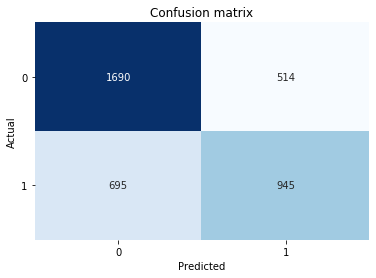

========= Eperiment -  df_A_B+W2V CBOW+LR  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-256
df_A_B+W2V CBOW+SVC linear
              precision    recall  f1-score   support

           0       0.70      0.76      0.73      2204
           1       0.64      0.56      0.60      1640

    accuracy                           0.68      3844
   macro avg       0.67      0.66      0.67      3844
weighted avg       0.68      0.68      0.68      3844



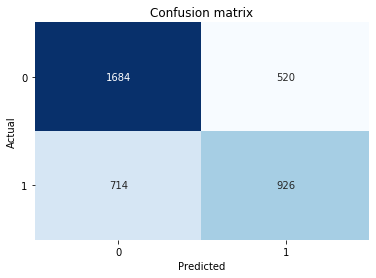

========= Eperiment -  df_A_B+W2V CBOW+SVC linear  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-257
df_A_B+W2V CBOW+SVC rbf
              precision    recall  f1-score   support

           0       0.69      0.81      0.75      2204
           1       0.67      0.52      0.59      1640

    accuracy                           0.69      3844
   macro avg       0.68      0.67      0.67      3844
weighted avg       0.69      0.69      0.68      3844



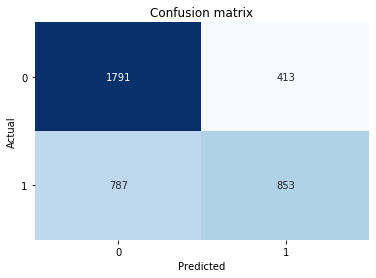

========= Eperiment -  df_A_B+W2V CBOW+SVC rbf  =========
https://app.neptune.ai/codekcg23/Research-Experiments/e/RES-258
 ====  W2V CBOW  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR,0.685484,0.609874,0.576220,0.647704,0.671504
SVC linear,0.678980,0.600130,0.564634,0.640387,0.664350
SVC rbf,0.687825,0.587061,0.520122,0.673776,0.666368


 ====  df_A_B  ==== 


,Accuracy,F1-score,Recall,Precision,AUC
LR+W2V skipgram,0.672737,0.576431,0.521951,0.643609,0.653444
SVC linear+W2V skipgram,0.671176,0.573837,0.518902,0.641780,0.651693
SVC rbf+W2V skipgram,0.684443,0.575726,0.501829,0.675144,0.661078
LR+W2V CBOW,0.685484,0.609874,0.576220,0.647704,0.671504
SVC linear+W2V CBOW,0.678980,0.600130,0.564634,0.640387,0.664350
SVC rbf+W2V CBOW,0.687825,0.587061,0.520122,0.673776,0.666368


,Accuracy,F1-score,Recall,Precision,AUC
df_A+W2V skipgram+LR,0.713550,0.264550,0.165563,0.657895,0.563335
df_A+W2V skipgram+SVC linear,0.701700,0.107858,0.057947,0.777778,0.525234
df_A+W2V skipgram+SVC rbf,0.689335,0.009852,0.004967,0.600000,0.501736
df_A+W2V CBOW+LR,0.713550,0.345882,0.243377,0.597561,0.584666
df_A+W2V CBOW+SVC linear,0.706852,0.157037,0.087748,0.746479,0.537143
df_A+W2V CBOW+SVC rbf,0.689851,0.009868,0.004967,0.750000,0.502109
df_B+W2V skipgram+LR,0.708508,0.746460,0.787850,0.709201,0.700730
df_B+W2V skipgram+SVC linear,0.706933,0.748422,0.800386,0.702794,0.697771
df_B+W2V skipgram+SVC rbf,0.696954,0.746374,0.818708,0.685784,0.685017
df_B+W2V CBOW+LR,0.716387,0.751838,0.788814,0.718174,0.709286


In [29]:
## longer stemmer > change classifer feature to use preprocessor and flag
classifier_feature({'df_A':df_A,'df_B':df_B,'df_A_B':df_A_B}, model_dict, feature_dict)